# Topic Subscription AB Test Analysis 

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

** 3 August 2022**

[TASK](https://phabricator.wikimedia.org/T280897) | [CODEBASE](https://github.com/wikimedia-research/Topic-notifications-analysis-2022)

# Table of Contents

1. [Introduction](#Introduction)
2. [Methodology](#Methodology)
3. [Data exploration](#Data-exploration)
4. [Key Performance Indicator](#Key-Performance-Indicator)
5. [Curiosities](#Curiosities)
6. [Guardrails](#Guardrails)


# Introduction

The Wikimedia Foundation's [Editing team](https://www.mediawiki.org/wiki/Editing_team#:~:text=The%20Editing%20team%20is%20the,tools%20like%20TemplateData%20and%20Citoid.) is working to improve how contributors communicate on Wikipedia using talk pages through a series of incremental improvements that will be released over time.

As part of this effort, the Editing team is working to to improve the notifications editors receive for the wikitext talk page conversations they are interested in. This work is intended to increase the likelihood Junior and Senior Contributors receive timely and relevant responses to the comment they post and conversations they start on wikitext talk pages, regardless of the tool used to publish these comments and conversations. 

The team ran an AB test of the notifications feature from 2 June 2022 through 15 July 2022 to assess the efficacy of this new feature and determine if topic subscriptions should be offered to all logged in volunteers at all Wikimedia sites by default. The test included all logged-in users that edited at one the 20 participating Wikipedias  during the duration of the AB test (see full list of [participating Wikipedias in task description](https://phabricator.wikimedia.org/T304027) and conditions outlined in the methodology section below). During this test, 50% of users included in the test had the Manual and Automatic topic subsctiptions automatically enabled, and 50% did not.

You can find more information about features of this tool and project updates on the [project page](https://www.mediawiki.org/w/index.php?title=Talk_pages_project/Notifications&useskin=vector-2022).

# Methodology

The AB test was run on a per Wikipedia basis and logged-in contributors included in the test were randomly assigned to either the control (topic subscription features disabled by default) or treatment (new topic tool enabled by default) based on the user Id. All of the participating wikis have access the same set of other tools: new topic and reply tool and editing interfaces.

Users at these Wikipedias were still able to turn the tool on or off the topic subscription preferences in Special:Preferences; however, they remained in the same group they were buketed in for the duration of the test. For this analysis, we also did not exclude users that may have previously used or enabled the Topic Subscription feature, instead, we used available instrumentation to identify these users in the analyis when needed.

Upon conclusion of the test on 15 July 2022, we recorded a total of 54,138 comments posted on a talk page by 9,997 distinct logged-in contributors across all experience levels.  A total of 4,781 (48%) of these contributors were identified as Junior Contributors. 

We used data logged in the following sources to track user talk page behavior and preference changes during the AB test:

* [EditAttemptStep](https://schema.wikimedia.org/#!//secondary/jsonschema/analytics/legacy/editattemptstep) and [talk_page_edit](https://schema.wikimedia.org/#!/secondary/jsonschema/analytics/mediawiki/talk_page_edit): Talk page edit attempts and comments by distinct users in the AB test
* [Mediawiki user_properties](https://www.mediawiki.org/wiki/Manual:User_properties_table/en?useskin=vector-2022) and [discussiontools_subscription](https://www.mediawiki.org/wiki/Extension:DiscussionTools/discussiontools_subscription_table?useskin=vector-2022): Topic subscription preference changes and current status
* [Echo Notification](https://www.mediawiki.org/wiki/Extension:Echo/echo_notification_table?useskin=vector-2022): Notifications sent and read by users.

See the following Phabricator tickets for further details regarding instrumentation and implementation of the AB test:
* [Implement Topic Subscription AB Test bucketing](https://phabricator.wikimedia.org/T304030)
* [AB Test start](https://phabricator.wikimedia.org/T304029)

In [123]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [5]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
    library(lubridate)
    set.seed(5)
    # Tables:
    library(gt)
    library(gtsummary)
})

In [92]:
options(repr.plot.width = 20, repr.plot.height = 10)

In [1]:
# Collect all edit attempts that were talk page comments
query <- "SELECT
  date_format(eas.dt, 'yyyy-MM-dd') as attempt_dt,
  date_format(tpe.dt, 'yyyy-MM-dd') as save_dt,
  event.editing_session_id as edit_attempt_id,
  wiki AS wiki,
  event.bucket AS experiment_group,
  event.editor_interface as interface,
  event.integration as integration,
  event.user_id as user_id,
  event.is_oversample AS is_oversample,
  IF(tpe.session_id IS NOT NULL, 'comment_posted', 'no_comment_posted') AS edit_save_status,
  tpe.component_type AS comment_type,
  tpe.topic_id AS topic_id,
  tpe.comment_id AS comment_id,
  tpe.comment_parent_id AS comment_parent_id,
  event.user_editcount AS experience_level
FROM event.editattemptstep eas
LEFT JOIN 
 event.mediawiki_talk_page_edit tpe
 ON  event.editing_session_id = tpe.session_id
 AND wiki = tpe.`database`
   AND tpe.Year = 2022
  AND ((tpe.month = 06 AND tpe.day >= 02) OR (tpe.month = 07 and tpe.day <= 15))
WHERE
-- AB test timline
  eas.Year = 2022
   AND ((eas.month = 06 AND eas.day >= 02) OR (eas.month = 07 and eas.day <= 15))
 -- remove bots
   AND useragent.is_bot = false
-- review all talk namespaces
   AND event.page_ns % 2 = 1
-- only test events
   AND event.bucket in ('test', 'control')
   AND event.platform = 'desktop'
   AND event.action = 'init'
-- review participating wikis list
   AND wiki IN ('amwiki', 'arzwiki', 'bnwiki', 'eswiki', 'fawiki', 'frwiki', 'hewiki',  'hiwiki',  'idwiki', 'itwiki',  'jawiki',  
 'kowiki', 'nlwiki', 'omwiki', 'plwiki', 'ptwiki',  'thwiki',
    'ukwiki', 'viwiki','zhwiki')
-- only logged in users
   AND event.user_id != 0 "

In [2]:
topic_events <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [6]:
# Data cleaning and reformating

# reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
topic_events$user_id <-
  as.character(paste(topic_events$user_id, topic_events$wiki, sep ="-"))

# divide experiene level groups
topic_events <- topic_events %>%
    mutate(experience_group = cut(as.numeric(experience_level), 
                                         breaks = c(0, 100, 500, 
                                                    Inf), 
                                         labels = c('0-100 edits', '101-500 edits', 'over 500 edits'), include.lowest = TRUE))

#clarfiy wiki names
topic_events <- topic_events %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'amwiki' ~ "Amharic Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'zhwiki' ~ "Chinese Wikipedia", 
      wiki == 'nlwiki' ~ 'Dutch Wikipedia', 
      wiki == 'arzwiki' ~ 'Egyptian Wikipedia', 
      wiki == 'frwiki' ~ 'French Wikipedia', 
      wiki == 'hewiki' ~ 'Hebrew Wikipedia', 
      wiki == 'hiwiki' ~ 'Hindi Wikipedia', 
      wiki == 'idwiki' ~ 'Indonesian Wikipedia', 
      wiki == 'itwiki' ~ 'Italian Wikipedia',  
      wiki == 'jawiki' ~ 'Japanese Wikipedia',    
      wiki == 'kowiki' ~ 'Korean Wikipedia', 
      wiki == 'omwiki' ~ 'Oromo Wikipedia', 
      wiki == 'fawiki' ~ 'Persian Wikipedia', 
      wiki == 'plwiki' ~ 'Polish Wikipedia',   
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia', 
      wiki == 'eswiki' ~ 'Spanish Wikipedia', 
      wiki == 'thwiki' ~ 'Thai Wikipedia',   
      wiki == 'ukwiki' ~ 'Ukrainian Wikipedia', 
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia'   
    )
  ) 


# Data exploration

We first explored the numbers of talk page edit attempts posted by users in each experiment group in the AB test to understand the scale and distribution of events across all participating wikis.

### Overall Talk Page Edit Attempts

In [7]:
talk_page_attempts_bygroup <- topic_events %>%
   #filter(is_oversample == 'false') %>% #All Discussion Tool events are oversampled - removing to check balance.
  group_by(experiment_group, edit_save_status) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id), .groups = 'drop')

talk_page_attempts_bygroup

experiment_group,edit_save_status,users,attempts
<chr>,<chr>,<int>,<int>
control,comment_posted,4990,27258
control,no_comment_posted,6249,22821
test,comment_posted,5021,26880
test,no_comment_posted,6094,21004


### Talk Page Edit Attempts by Experience Group

In [8]:
talk_page_attempts_byjunior <- topic_events %>%
 #filter(edit_save_status == 'comment_posted')  %>%
  mutate(experience_group =
         case_when(
             experience_level < 100 ~ "under 100 edits",
             experience_level >=100 & experience_level <= 500 ~ "between 100 and 500 edits",
             experience_level > 500 ~ "over 500 edits"
             )) %>%
  group_by(experience_group, experiment_group, edit_save_status) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id), .groups = 'drop')

talk_page_attempts_byjunior

experience_group,experiment_group,edit_save_status,users,attempts
<chr>,<chr>,<chr>,<int>,<int>
between 100 and 500 edits,control,comment_posted,556,2104
between 100 and 500 edits,control,no_comment_posted,524,1486
between 100 and 500 edits,test,comment_posted,606,2341
between 100 and 500 edits,test,no_comment_posted,501,1356
over 500 edits,control,comment_posted,2131,20320
over 500 edits,control,no_comment_posted,2029,14722
over 500 edits,test,comment_posted,2116,19484
over 500 edits,test,no_comment_posted,1970,12907
under 100 edits,control,comment_posted,2384,4834


There is a roughly equivalent number of both senior and junior contributors that have posted a comment on a talk page during the duration of the AB test. In addition, there are no signficant differences in the the number of comments posted between test and control groups.

###  Comments Posted by Wiki

In [192]:
talk_page_comments_bywiki <- topic_events %>%
  filter(edit_save_status == 'comment_posted')  %>%
  group_by(experiment_group, wiki) %>%
  summarise(n_users = n_distinct(user_id),
        n_comments = n_distinct(edit_attempt_id))  %>%
  arrange(wiki)

talk_page_comments_bywiki

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,wiki,n_users,n_comments
<chr>,<chr>,<int>,<int>
control,Amharic Wikipedia,2,2
test,Amharic Wikipedia,1,1
control,Bengali Wikipedia,76,287
test,Bengali Wikipedia,83,751
control,Chinese Wikipedia,353,1356
test,Chinese Wikipedia,352,1586
control,Dutch Wikipedia,218,1017
test,Dutch Wikipedia,208,981
control,Egyptian Wikipedia,4,7


There is not a sufficient sample of talk page comments and edits logged been made on Amharic, Egyptian, Oromo, Hindi and Thai Wikipedia during the AB test to conclude any results for these particular wikis; however, we will include them in the overall analysis.

# Key Performance Indicator 

## Average time duration between post and response

For all comments and new topics with a response, the average time duration from "Person A" posting on a talk page and "Person B" posting a response, grouped by the experience level of "Person A".

For this analysis, I reviewed all comments posted on talk pages by users in the AB test and found the time a comment was posted in response either to comment or topic (top level comment). I then reviewed the averages of response times identifed over the course of the AB test for each test group and experience level to identify an differences. Note: We do not know if all of the users in the AB test were subscribed to the topic at the time of their comment or response but are interested in the overall impact Topic Subscriptions has on the rates at which people review responses to things they say on wiki.

IDEAS FOR FURTHER INVESTIGATION:
* Look into how many of each experience level has subscribed to a comment. Are more Junior or Senior Contributors subscribing to a comment?
* What percentage of these responses are people responding to their own comment? Can we identify and remove these?


In [9]:
# isolate only to comments that received a response
# FixMe: Expand to include topics with responses as well

query <- "
-- find all commenters and their experience level
WITH comments_posted AS (
SELECT
    ctpe.dt as comment_dt,
    comment_id,
    topic_id,
    `database` AS  wiki,
    performer.user_edit_count AS experience_level
FROM event.mediawiki_talk_page_edit ctpe
INNER JOIN 
 event.editattemptstep eas
 ON  session_id = eas.event.editing_session_id 
 AND `database` = eas.wiki 
 AND eas.Year = 2022
AND ((eas.month = 06 AND eas.day >= 02) OR (eas.month = 07 and eas.day <= 18))
WHERE
component_type = 'comment'
AND ctpe.Year = 2022
AND ((ctpe.month = 06 AND ctpe.day >= 02) OR (ctpe.month = 07 and ctpe.day <= 18))
AND performer.user_id != 0
AND eas.event.bucket in ('test', 'control')
AND eas.useragent.is_bot = false
)

-- find all responses to those comments and the time they were posted
SELECT
  cp.comment_dt,
  tpe.dt as response_dt,
  cp.comment_id,
  cp.topic_id,
  cp.experience_level,
  tpe.comment_parent_id AS comment_parent_id,
  tpe.comment_id AS response_id,
  event.action AS action,
  event.editing_session_id as edit_attempt_id,
  cp.wiki AS wiki,
  tpe.component_type AS response_type,
  event.bucket AS experiment_group,
  event.user_id as user_id
FROM  event.mediawiki_talk_page_edit tpe
INNER JOIN 
 event.editattemptstep eas
 ON  tpe.session_id = eas.event.editing_session_id 
 AND tpe.`database` = eas.wiki 
 AND eas.Year = 2022
  AND ((eas.month = 06 AND eas.day >= 02) OR (eas.month = 07 and eas.day <= 18))
INNER JOIN comments_posted cp
ON (tpe.comment_parent_id = cp.comment_id OR tpe.comment_parent_id = cp.topic_id)  --confirms reponse to topic or comment
AND tpe.`database` = cp.wiki
WHERE
-- AB test timline
  tpe.Year = 2022
  AND ((tpe.month = 06 AND tpe.day >= 02) OR (tpe.month = 07 and tpe.day <= 18))
 -- remove bots
  AND eas.useragent.is_bot = false
-- review all talk namespaces
  AND event.page_ns % 2 = 1
  AND (tpe.component_type = 'response' OR tpe.component_type = 'comment')
  AND tpe.dt > cp.comment_dt -- response occured after post
  AND event.action = 'saveSuccess' 
-- only test events
  AND eas.event.bucket in ('test', 'control')
   AND event.platform = 'desktop'
-- review participating wikis list
  AND cp.wiki IN ('amwiki', 'arzwiki', 'bnwiki', 'eswiki', 'fawiki', 'frwiki', 'hewiki',  'hiwiki',  'idwiki', 'itwiki',  'jawiki',  
 'kowiki', 'nlwiki', 'omwiki', 'plwiki', 'ptwiki',  'thwiki',
    'ukwiki', 'viwiki','zhwiki')
-- only logged in users
  AND tpe.performer.user_id != 0
"


In [10]:
topic_response_data <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [11]:
# Reformat dates

topic_response_data$response_dt <- as.POSIXct(topic_response_data$response_dt, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")
topic_response_data$comment_dt <- as.POSIXct(topic_response_data$comment_dt, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")

In [12]:
# Data cleaning and refactoring

#set factor levels with correct baselines
topic_response_data$experiment_group <-
  factor(
    topic_response_data$experiment_group,
    levels = c("control", "test"),
    labels = c("control", "test")
  )


# reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
topic_response_data$user_id <-
  as.character(paste(topic_response_data$user_id, topic_response_data$wiki, sep ="-"))


#clarfiy wiki names
topic_response_data <- topic_response_data  %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'amwiki' ~ "Amharic Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'zhwiki' ~ "Chinese Wikipedia", 
      wiki == 'nlwiki' ~ 'Dutch Wikipedia', 
      wiki == 'arzwiki' ~ 'Egyptian Wikipedia', 
      wiki == 'frwiki' ~ 'French Wikipedia', 
      wiki == 'hewiki' ~ 'Hebrew Wikipedia', 
      wiki == 'hiwiki' ~ 'Hindi Wikipedia', 
      wiki == 'idwiki' ~ 'Indonesian Wikipedia', 
      wiki == 'itwiki' ~ 'Italian Wikipedia',  
      wiki == 'jawiki' ~ 'Japanese Wikipedia',    
      wiki == 'kowiki' ~ 'Korean Wikipedia', 
      wiki == 'omwiki' ~ 'Oromo Wikipedia', 
      wiki == 'fawiki' ~ 'Persian Wikipedia', 
      wiki == 'plwiki' ~ 'Polish Wikipedia',   
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia', 
      wiki == 'eswiki' ~ 'Spanish Wikipedia', 
      wiki == 'thwiki' ~ 'Thai Wikipedia',   
      wiki == 'ukwiki' ~ 'Ukrainian Wikipedia', 
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia'   
    )
  ) 



In [13]:
# divide and define experience level groups

topic_response_data_exp <- topic_response_data %>%
    mutate(experience_group = cut(as.numeric(experience_level), 
                                         breaks = c(0, 100, 500, 
                                                    Inf), 
                                         labels = c('0-100 edits', '101-500 edits', 'over 500 edits'), include.lowest = TRUE))


## Distribution of response time

We first reviewed the distibution of response times. Since both the test and control data sets are highly skewed with most response times occuring under 1 hour, I'd recommend looking at the median instead of the mean response time to identify the typical response time of a user.

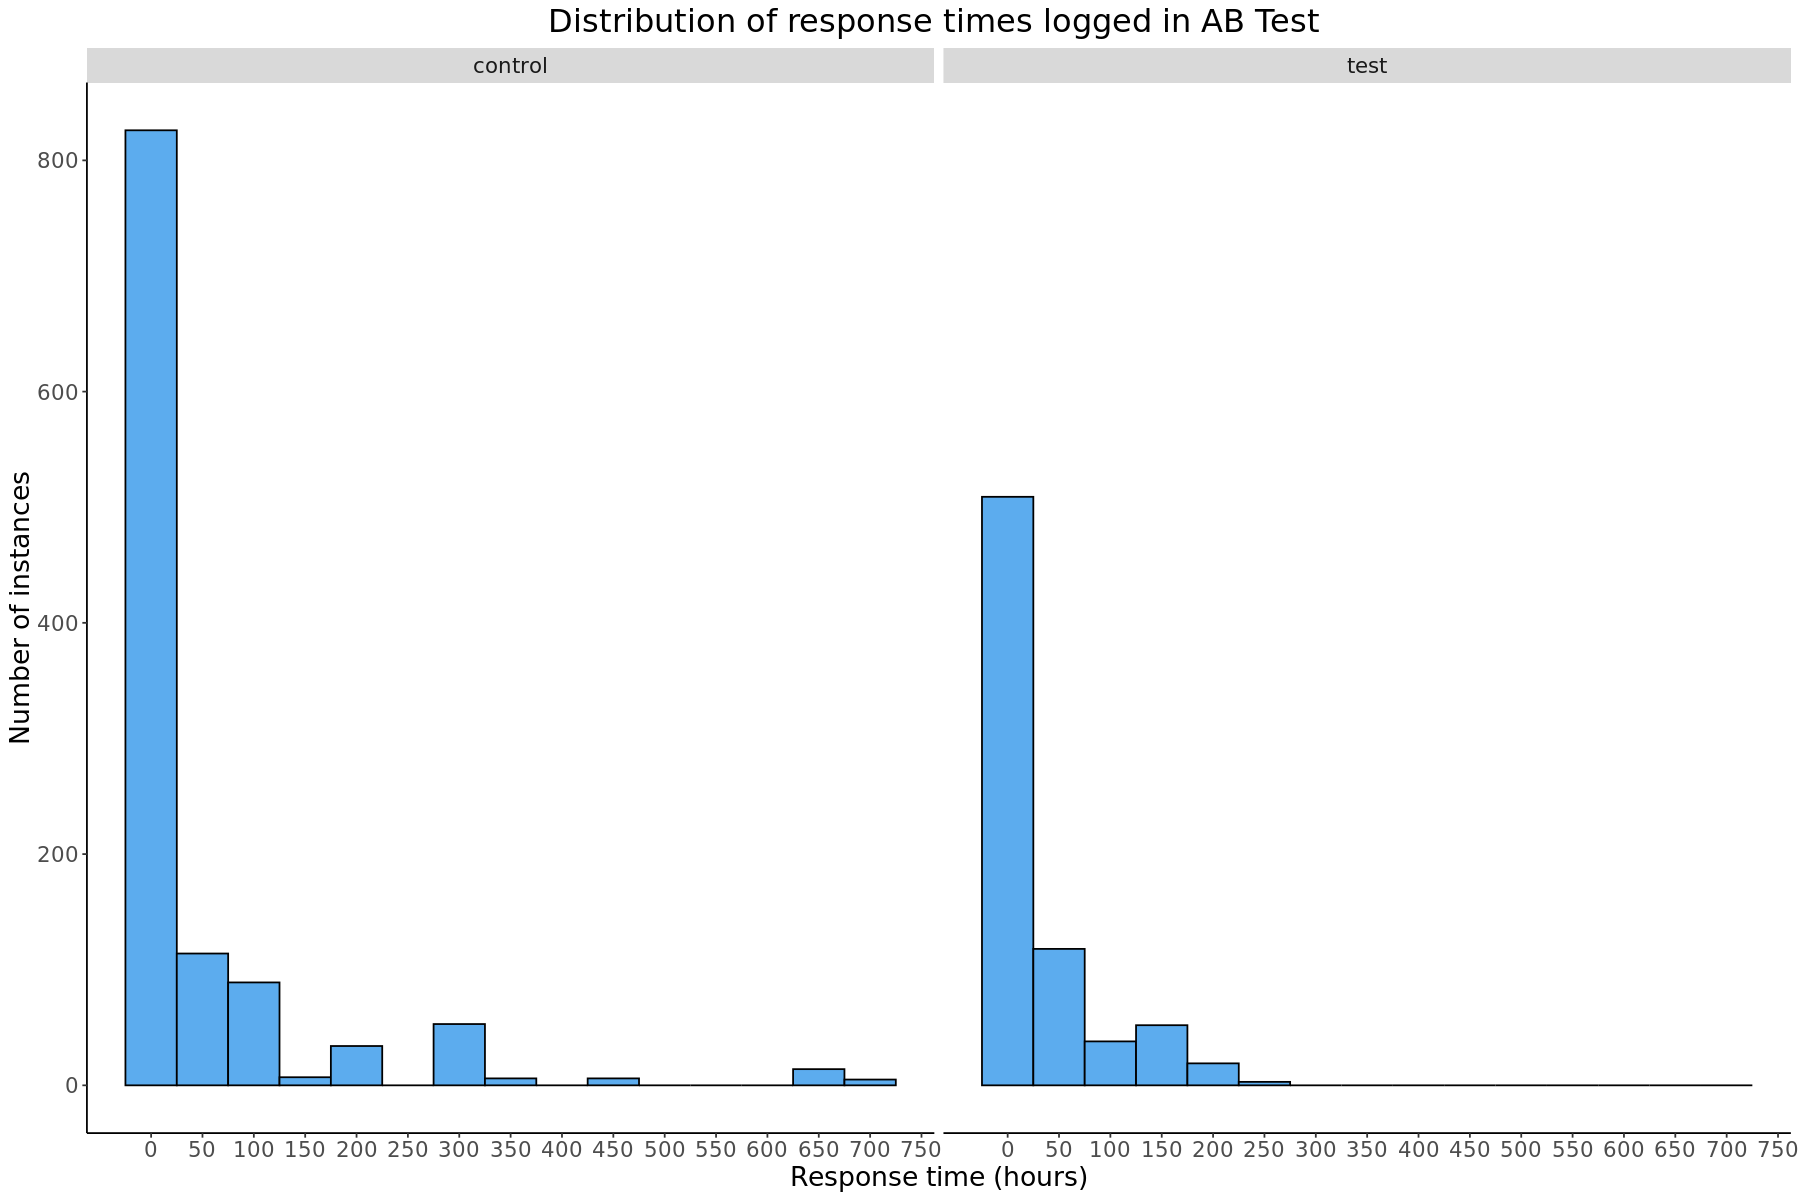

In [23]:
# Create histogram

response_histogram <- topic_response_data_exp %>%
    mutate(response_time = difftime(response_dt, comment_dt, units = "secs")) %>%  
    #filter(response_time < 3600)  %>%  #remove significant outliers to help more clearly see distribution of majority
    ggplot(aes(x=response_time/3600)) +  #round to nearest hour
    geom_histogram(color = "black", binwidth = 50, fill = 'steelblue2') +
    facet_wrap(~ experiment_group) +
    scale_x_continuous(labels = scales::comma, breaks=seq(0,800,50)) +
    labs (title = "Distribution of response times logged in AB Test ",
          y = "Number of instances",
         x= "Response time (hours)")   + 
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

response_histogram

ggsave("Figures/response_time_histogram.png",response_histogram, width = 16, height = 8, units = "in", dpi = 300)

### How many responses are provided under or over 10 days?

In [34]:
length_response_times <- topic_response_data_exp %>%
    mutate(response_time = difftime(response_dt, comment_dt, units = "secs"),
          response_time=response_time/3600,
          response_time_group = ifelse(response_time > 240, "long", "short"))  %>%  
    group_by(experiment_group, response_time_group) %>%
    summarise(n_responses = n_distinct(comment_id))

length_response_times 

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,response_time_group,n_responses
<fct>,<chr>,<int>
control,long,5
control,short,106
test,long,1
test,short,69


There are fewer outliers (long response times) in the test group. In the control group, 4.5% of responses were provided over 10 days (240 hours) after the intial comment while in the treatment group only 1.4% of responses were provided over 10 days.


## Overall across both test groups

In [38]:
# find the average time difference

avg_time_response_overall <- topic_response_data_exp %>%
    mutate(response_time = difftime(response_dt, comment_dt, units = "mins")) %>%  ## add column to show response time
    group_by(experiment_group) %>%
    summarise(median_response_time = round(median(response_time), 0),
             mean_response_time = round(mean(response_time), 0)
             ) 
   

avg_time_response_overall

`summarise()` ungrouping output (override with `.groups` argument)



experiment_group,median_response_time,mean_response_time
<fct>,<drtn>,<drtn>
control,90 mins,2920 mins
test,39 mins,1861 mins


#### Quick look at percentiles

In [43]:
avg_time_response_percentiles <- topic_response_data_exp %>%
    mutate(response_time = difftime(response_dt, comment_dt, units = "mins")) %>%  ## add column to show response time
    group_by(experiment_group) %>%
    summarise(quantile = scales::percent(c(0.25, 0.5, 0.75)),
            response_time = round(quantile(response_time, c(0.25, 0.5, 0.75)), 0) )%>%
    pivot_wider(names_from = quantile, values_from = response_time)
    

avg_time_response_percentiles

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,25%,50%,75%
<fct>,<drtn>,<drtn>,<drtn>
control,6 mins,90 mins,2713 mins
test,2 mins,39 mins,2620 mins


The average is heavily influenced by the 90th percentile, the tail, rather than the majority of the response times.

75% of response times are complete in under 3000 minutes. The 50% percentile indicated that half of the response times were below and half were above this value.

Based on this, I recommend we use the median (50th) percentile as a better indicator of the typical response time in the test.

In [45]:
# join the two data sets
# find percent reponse rate
response_time_stats <- inner_join(avg_time_response_overall, avg_time_response_percentiles, by = c("experiment_group")) 
response_time_stats 


experiment_group,median_response_time,mean_response_time,25%,50%,75%
<fct>,<drtn>,<drtn>,<drtn>,<drtn>,<drtn>
control,90 mins,2920 mins,6 mins,90 mins,2713 mins
test,39 mins,1861 mins,2 mins,39 mins,2620 mins


In [452]:
# Create table of completion rate
avg_time_response_overall_table <- avg_time_response_overall%>%
  gt() %>%
  tab_header(
    title = "Summary of response times across all participating Wikipedias",
  )  %>%
  cols_label(
    experiment_group = "Experiment Group",
    median_response_time = "Median response time (minutes)",
    mean_response_time = "Mean response time (minutes)"
  ) %>%
  tab_footnote(
    footnote = "Defined as the midpoint of identified time durations from Person A posting on a talk page and Person B posting a response",
    locations = cells_column_labels(
      columns = "median_response_time"
    )
  ) %>%
  tab_footnote(
    footnote = 'Test: Topic subscriptions enabled by default; Control: Topic subscriptions not enabled',
    locations = cells_column_labels(
      columns = 'experiment_group')
    ) %>%
   tab_footnote(
    footnote = 'Defined as the average time duration from Person A posting on a talk page and Person B posting a response"',
    locations = cells_column_labels(
      columns = 'mean_response_time')
    ) %>%
    gtsave(
    "avg_time_response_overall_table.html", inline_css = TRUE)

IRdisplay::display_html(data = avg_time_response_overall_table , file = "avg_time_response_overall_table.html")

"1 Test: Topic subscriptions enabled by default; Control: Topic subscriptions not enabled 2 Defined as the midpoint of identified time durations from Person A posting on a talk page and Person B posting a response 3 Defined as the average time duration from Person A posting on a talk page and Person B posting a response"""


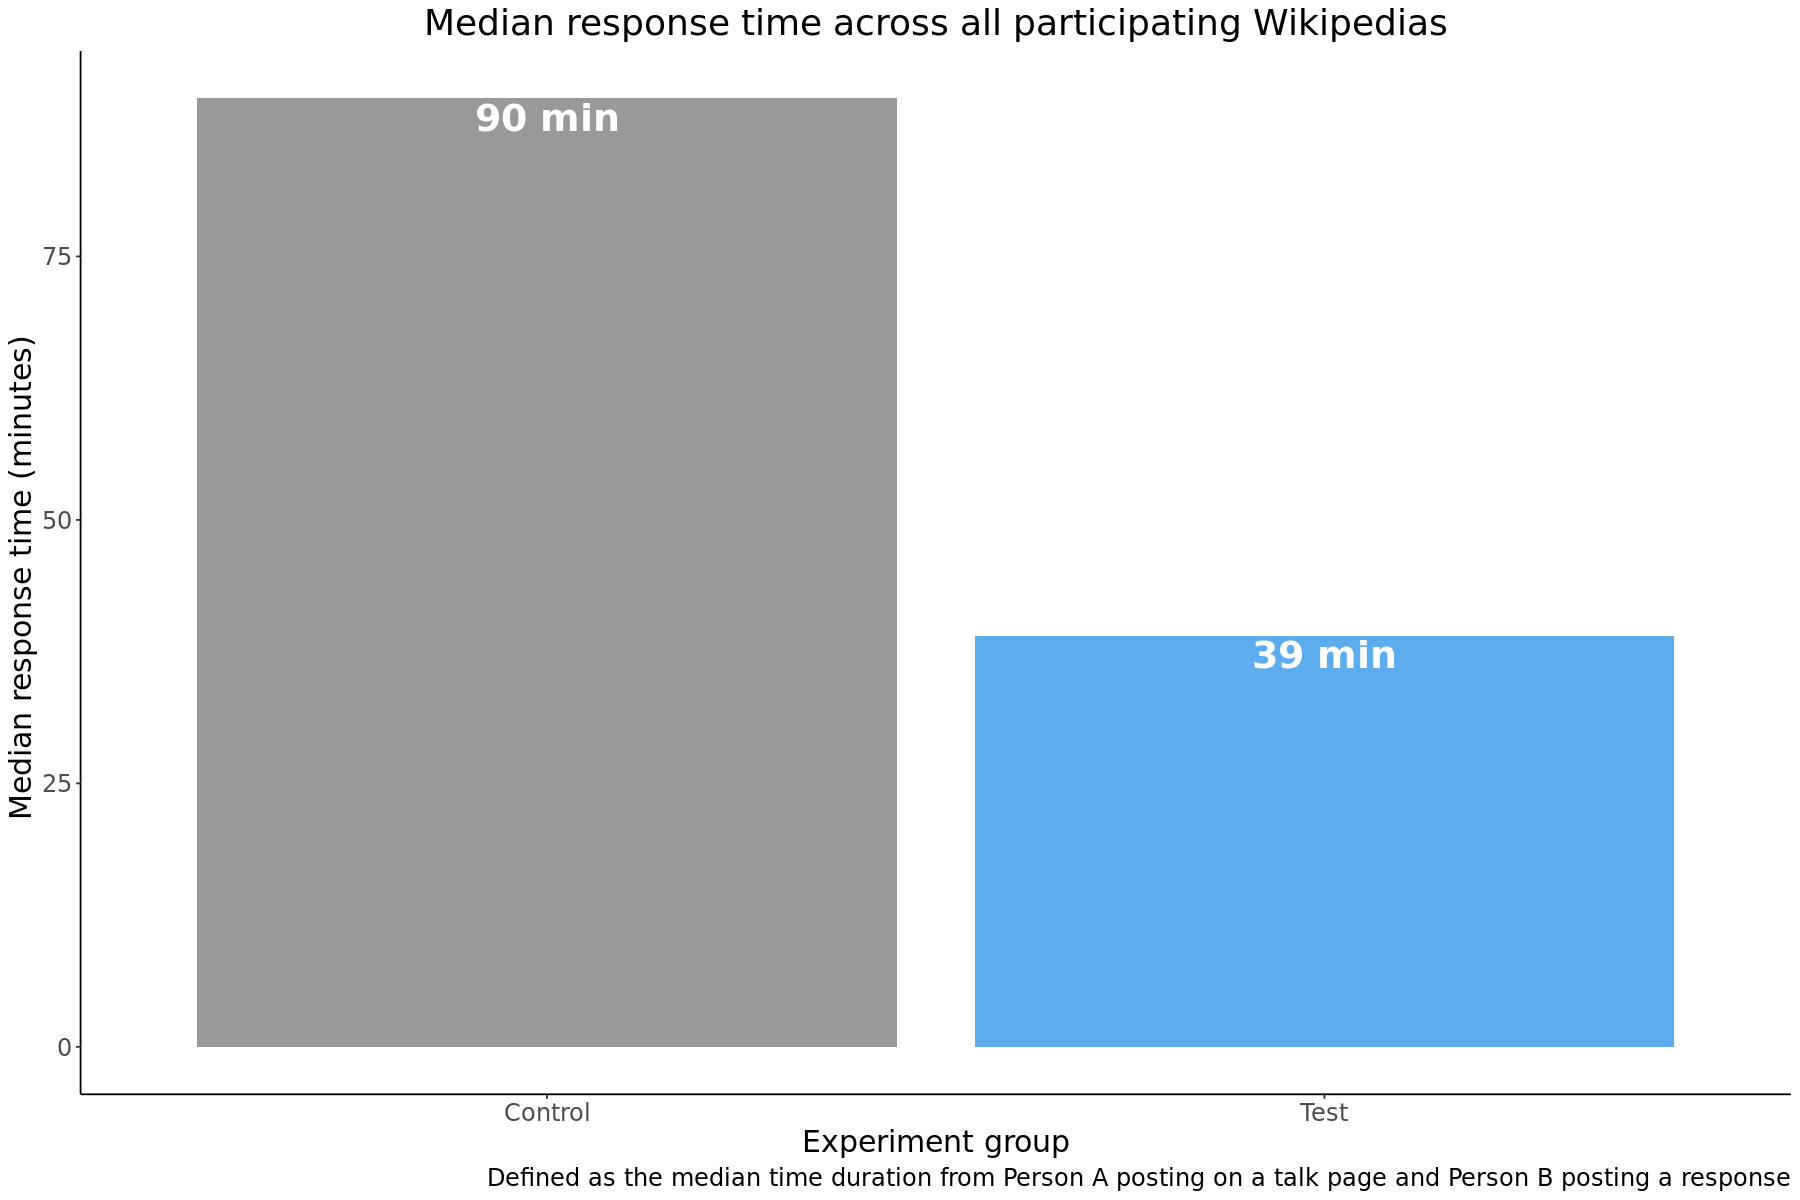

In [46]:
p <- avg_time_response_overall  %>%
    ggplot(aes(x= experiment_group, y = median_response_time, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(median_response_time, "min"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous() +
    scale_x_discrete(labels = c("Control", "Test")) +
    labs (y = "Median response time (minutes) ",
          x = "Experiment group",
          title = "Median response time across all participating Wikipedias",
         caption = "Defined as the median time duration from Person A posting on a talk page and Person B posting a response")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/median_time_response_overall.png", p, width = 16, height = 8, units = "in", dpi = 300)

There was 51 minute decrease (57% decrease) in the median response time for the test group compared to the control group.

### By experience level

In [47]:
# find the average time difference by experience level

avg_time_response_byexp <- topic_response_data_exp %>%
    mutate(response_time = difftime(response_dt, comment_dt, units = "mins")) %>%  ## add column to show response time
    group_by(experiment_group, experience_group) %>%
     summarise(median_response_time_minutes = as.integer(median(response_time)),
             mean_response_time_minutes = as.integer(mean(response_time))) %>%
    arrange(experience_group)

avg_time_response_byexp

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,experience_group,median_response_time_minutes,mean_response_time_minutes
<fct>,<fct>,<int>,<int>
control,0-100 edits,62,249
test,0-100 edits,3,893
control,101-500 edits,34,7532
test,101-500 edits,55,1421
control,over 500 edits,90,2240
test,over 500 edits,311,2391


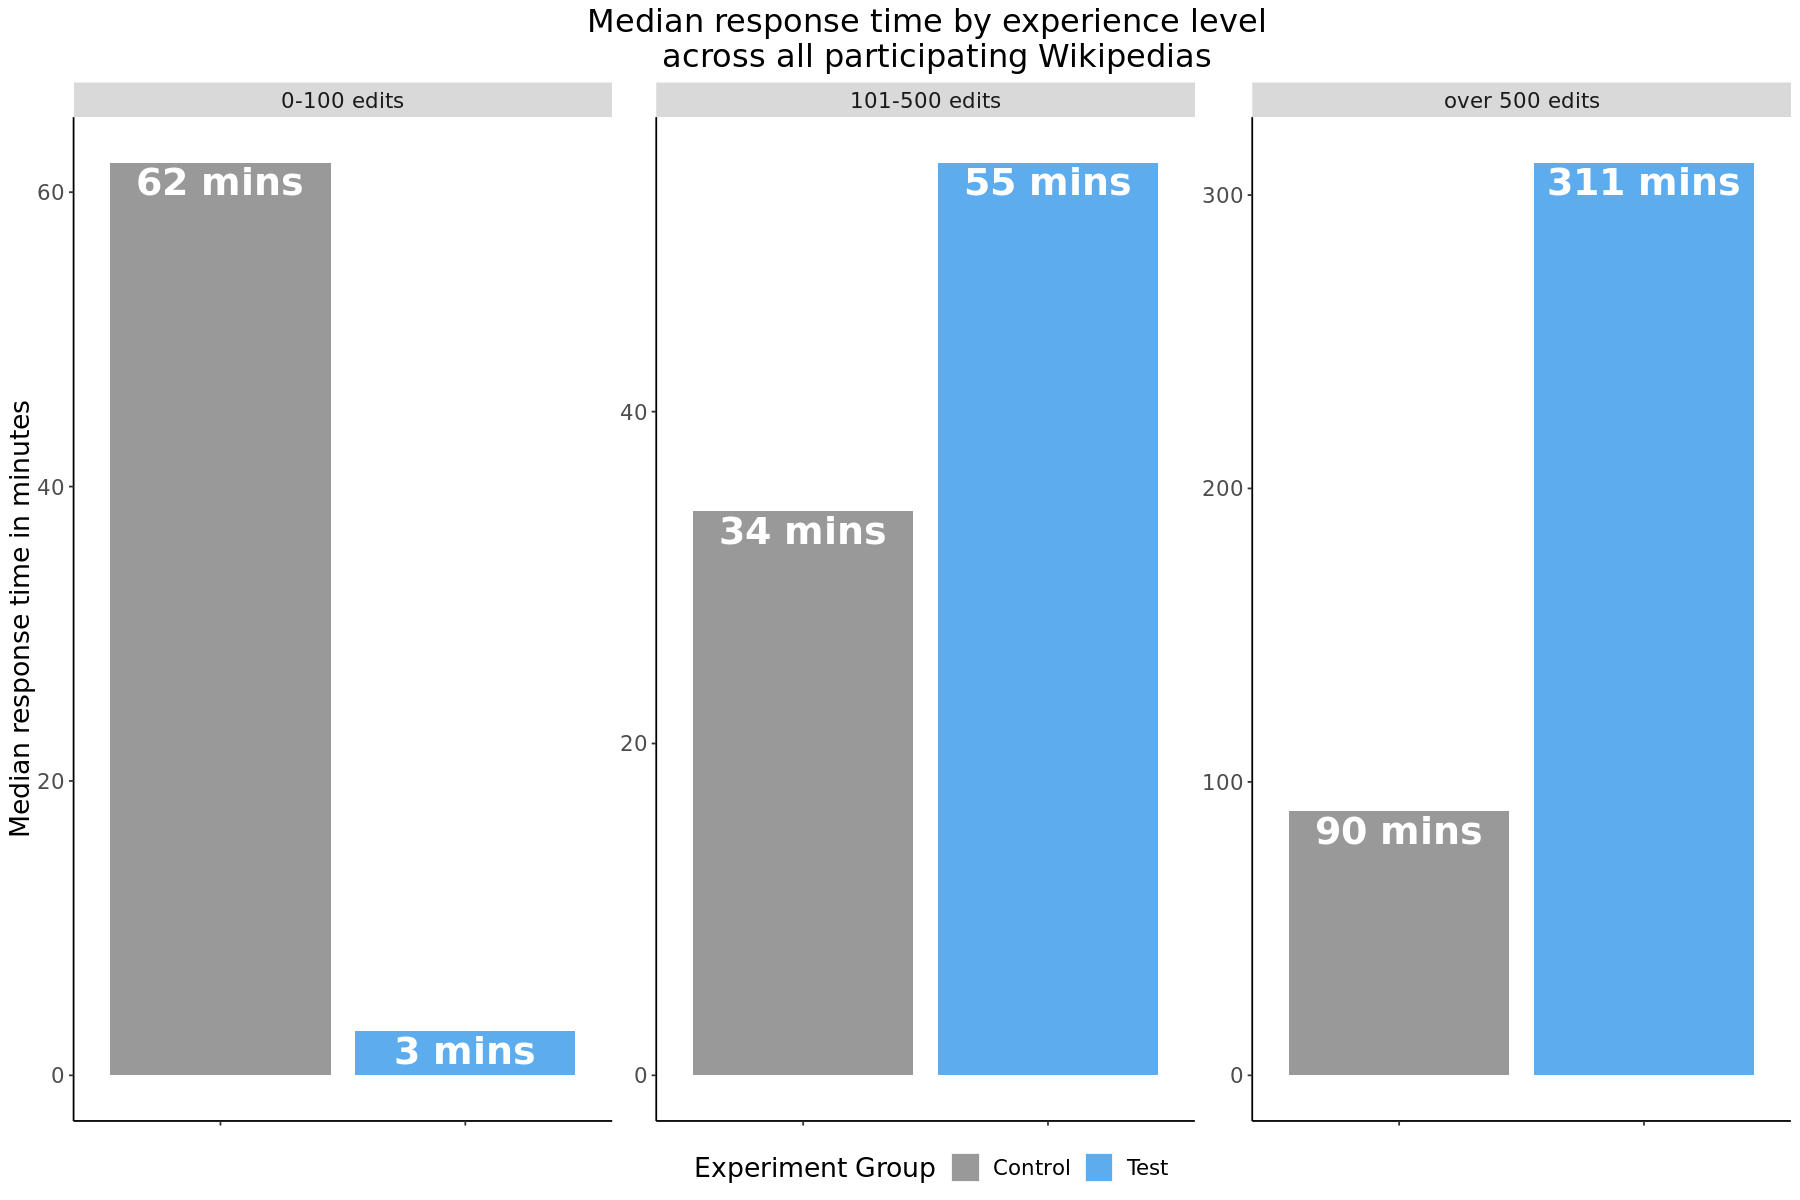

In [48]:
# Plot edit completion rates for each user on each wiki  

p <- avg_time_response_byexp %>%
    ggplot(aes(x= experiment_group, y = median_response_time_minutes, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(median_response_time_minutes, "mins"), fontface=2), vjust=1.2, size = 8, color = "white") +
    facet_wrap(~ experience_group, scales = "free_y") +
    scale_y_continuous() +
    labs (y = "Median response time in minutes",
          title = "Median response time by experience level \n across all participating Wikipedias"
          )+
      scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group", labels = c("Control", "Test"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

p 
ggsave("Figures/avg_time_response_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

When we split by experience group, the results are much more varied. We see a significant decrease (-95%) in median response times to Junior Contributors that posted a comment in the test group but an increase for Senior Contributors that posted a comment. Differing trends are seen for averages. 

Further investigation is likely needed to clarify these results. 

### By Wiki

In [61]:
# find the average time difference by wiki

avg_time_response_bywiki <- topic_response_data_exp %>%
    filter(! wiki %in% c('AmharicWikipedia', 'Egyptian Wikipedia', 
                         'Oromo Wikipedia', 'Hindi Wikipedia', 'Thai Wikipedia' , 'Bengali Wikipedia', 
                        'Dutch Wikipedia', 'Polish Wikipedia', 'Ukrainian Wikipedia', 
                        'Korean Wikipedia')) %>% # exclude wikis where there is not sufficient info
    mutate(response_time = difftime(response_dt, comment_dt, units = "mins")) %>%  ## add column to show response time
    group_by(experiment_group, wiki) %>%
     summarise(median_response_time_minutes = as.integer(median(response_time)),
             mean_response_time_minutes = as.integer(mean(response_time))) %>%
    arrange(wiki)

avg_time_response_bywiki

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,wiki,median_response_time_minutes,mean_response_time_minutes
<fct>,<chr>,<int>,<int>
control,Chinese Wikipedia,4953,5003
test,Chinese Wikipedia,5090,6378
control,French Wikipedia,64,1023
test,French Wikipedia,55,3167
control,Hebrew Wikipedia,2,3159
test,Hebrew Wikipedia,676,1600
control,Italian Wikipedia,5,12
test,Italian Wikipedia,2820,1549
control,Japanese Wikipedia,1401,4668


ERROR: Error: Unknown graphics device ''


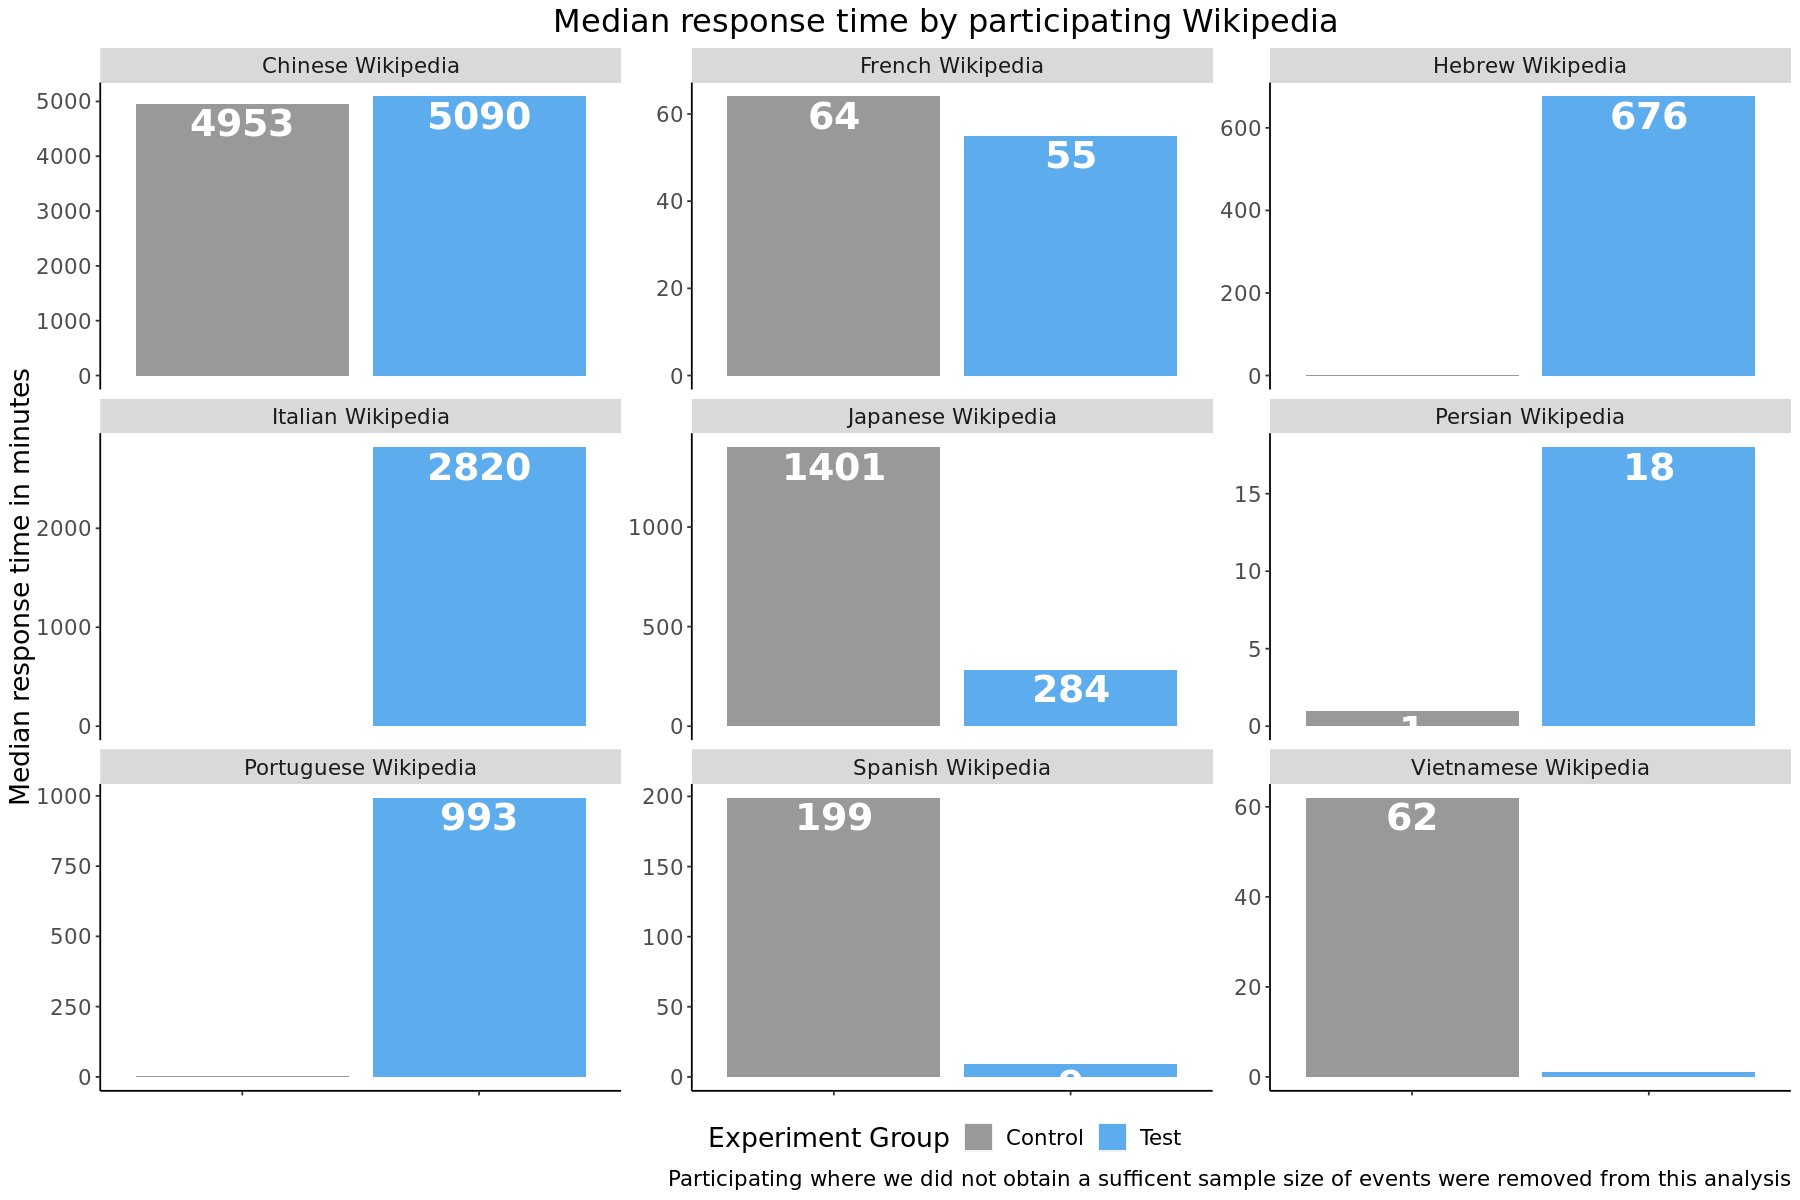

In [62]:
# Plot edit completion rates for each user on each wiki  

p <- avg_time_response_bywiki %>%
    ggplot(aes(x= experiment_group, y = median_response_time_minutes, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(median_response_time_minutes), fontface=2), vjust=1.2, size = 8, color = "white") +
    facet_wrap(~ wiki, scales = "free_y") +
    scale_y_continuous() +
    labs (y = "Median response time in minutes",
          title = "Median response time by participating Wikipedia",
          caption = "Participating where we did not obtain a sufficent sample size of events were removed from this analysis"
          )+
      scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group", labels = c("Control", "Test"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

p 
ggsave("Figures/avg_time_response_bywiki", p, width = 16, height = 8, units = "in", dpi = 300)

Results vary also on a per wikipedia basis with half of the participating wikis having signficant decrease in median response times and the other half having signficant increases. 

We observed signficant decreases in median response times for the following participating wikis: Spanish Wikipedia (-95% decrease), Japanese Wikipedia (-78% decrease), Vietnamese Wikipedia (-98% decrease), French Wikipedia (-16% decrease).

We observed signficant increases in median response times for the following participating wikis: Portuguese Wikipedia, Persian Wikipedia, Italian Wikipedia and Hebrew Wikipedia). Furhter investigation is needed to clarfiy these results. 

# Curiosities

# Curiosity #1: Average and total number of comments or new topics posted on talk pages by contributors that edit a talk page, grouped by experience level

## Total number of comments posted by users within each experiment group
### Overall

In [376]:
talk_page_comments_bygroup <- topic_events %>%
  filter(edit_save_status == 'comment_posted')  %>%
  group_by(experiment_group) %>%
  summarise(n_users = n_distinct(user_id),
        n_comments = n_distinct(edit_attempt_id))

talk_page_comments_bygroup

`summarise()` ungrouping output (override with `.groups` argument)



experiment_group,n_users,n_comments
<chr>,<int>,<int>
control,4990,27258
test,5021,26880


### Overall by comment type

In [323]:
talk_page_comments_bytype <- topic_events %>%
  filter(edit_save_status == 'comment_posted')  %>%
  group_by(experiment_group, comment_type) %>%
  summarise(n_users = n_distinct(user_id),
        n_comments = n_distinct(edit_attempt_id))

talk_page_comments_bytype

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,comment_type,n_users,n_comments
<chr>,<chr>,<int>,<int>
control,comment,357,663
control,response,3010,14775
control,topic,3295,11968
test,comment,362,706
test,response,3081,14288
test,topic,3296,12051


## Comments with a response

In [377]:
# Find all all topics or new comments that have received a response. 
# Topics with response - commment parent id = topic_id
# Comments with a response - comment_id = comment_parent id

comments_w_response <- topic_events %>%
    filter(comment_type != 'topic') %>%  #all topics by definition have a comment added to them
    filter(edit_save_status == 'comment_posted',
          comment_id %in% comment_parent_id |
          topic_id %in% comment_parent_id  ) %>% # comments and topics that recieved a response
 group_by(experiment_group) %>%
  summarise(n_users_wresponse = n_distinct(user_id),
        n_comments_wresponse = n_distinct(edit_attempt_id))


`summarise()` ungrouping output (override with `.groups` argument)



In [378]:
head(comments_w_response)

experiment_group,n_users_wresponse,n_comments_wresponse
<chr>,<int>,<int>
control,1249,5022
test,1235,4772


In [380]:
# find percent reponse rate
response_pct <- inner_join(talk_page_comments_bygroup, comments_w_response, by = c("experiment_group")) %>%
    group_by(experiment_group) %>%
    mutate(pct_users_w_reponse = paste0(round(n_users_wresponse/n_users * 100, 2), "%"),
           pct_comments_w_reponse = paste0(round(n_comments_wresponse/n_comments * 100, 2), "%"))
response_pct

experiment_group,n_users,n_comments,n_users_wresponse,n_comments_wresponse,pct_users_w_reponse,pct_comments_w_reponse
<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
control,4990,27258,1249,5022,25.03%,18.42%
test,5021,26880,1235,4772,24.6%,17.75%


There is a not a signficant difference in the number of users or comments posted on talk pages or the response rate within each group.

### Average daily number of comments or new topics across all contributors

In [470]:
avg_daily_comments <- topic_events %>%
    filter(edit_save_status == 'comment_posted') %>%
 group_by(save_dt, experiment_group) %>%
  summarise(n_comments_total = n_distinct(comment_id)) %>%
 group_by(experiment_group) %>%
summarise(n_comments_total = mean(n_comments_total))

avg_daily_comments

`summarise()` regrouping output by 'save_dt' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



experiment_group,n_comments_total
<chr>,<dbl>
control,668.3864
test,655.0000


### Average daily number of comments or new topic by contributors' experience level

In [468]:
## Average number of comments or new topics by each distinct contributor grouped by experience level

avg_daily_comments_bycontributor <- topic_events %>%
    filter(edit_save_status == 'comment_posted') %>%
 group_by(user_id,  experiment_group, experience_group)  %>%
  summarise(n_comments_total = n_distinct(comment_id))  %>%
 group_by(experiment_group, experience_group) %>%
summarise(avg_comments = round(mean(n_comments_total), 2))

avg_daily_comments_bycontributor

`summarise()` regrouping output by 'user_id', 'experiment_group' (override with `.groups` argument)

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,experience_group,avg_comments
<chr>,<fct>,<dbl>
control,0-100 edits,2.04
control,101-500 edits,3.80
control,over 500 edits,10.53
test,0-100 edits,2.12
test,101-500 edits,3.78
test,over 500 edits,10.12


There is also no signficant differences in the average number of comments posted by a distinct logged-in contributor in the AB test. In both groups, the number of average comments increase with as te contributors' edit experience increase.

# Curiosity 2: Percent of contributors that edit a talk page and start a new topic, grouped by the number of topics (e.g. 1-5, 6-10, 11-15, etc) they've started and experience level


## What percent of contributors edit a talk page and start a new topic?
### Overall

In [81]:
pct_editors_comments <- topic_events %>%
    group_by(experiment_group) %>%
    summarise(n_topic_posters = n_distinct(user_id[edit_save_status == 'comment_posted' &
                                               comment_type == 'topic']),
              n_comment_posters =  n_distinct(user_id[edit_save_status == 'comment_posted' &
                                               comment_type == 'comment']),
              n_talk_editors = n_distinct(user_id),
              pct_topic_posters = paste0(round(n_topic_posters/n_talk_editors * 100, 3), "%"),
              pct_commenter_posters = paste0(round(n_comment_posters/n_talk_editors * 100, 3), "%"))

pct_editors_comments

`summarise()` ungrouping output (override with `.groups` argument)



experiment_group,n_topic_posters,n_comment_posters,n_talk_editors,pct_topic_posters,pct_commenter_posters
<chr>,<int>,<int>,<int>,<chr>,<chr>
control,3295,357,8508,38.728%,4.196%
test,3296,362,8479,38.873%,4.269%


### By experience group

In [96]:
pct_editors_comments_exp <- topic_events %>%
    group_by(experiment_group, experience_group) %>%
    summarise(n_topic_posters = n_distinct(user_id[edit_save_status == 'comment_posted' &
                                               comment_type == 'topic']),
              n_comment_posters =  n_distinct(user_id[edit_save_status == 'comment_posted' &
                                               comment_type == 'comment']),
              n_talk_editors = n_distinct(user_id),
              pct_topic_posters = paste0(round(n_topic_posters/n_talk_editors * 100, 3), "%"),
              pct_commenter_posters = paste0(round(n_comment_posters/n_talk_editors * 100, 3), "%"))

pct_editors_comments_exp

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,experience_group,n_topic_posters,n_comment_posters,n_talk_editors,pct_topic_posters,pct_commenter_posters
<chr>,<fct>,<int>,<int>,<int>,<chr>,<chr>
control,0-100 edits,1455,63,5038,28.881%,1.25%
control,101-500 edits,362,29,801,45.194%,3.62%
control,over 500 edits,1525,265,2788,54.699%,9.505%
test,0-100 edits,1444,55,5040,28.651%,1.091%
test,101-500 edits,390,28,833,46.819%,3.361%
test,over 500 edits,1519,281,2737,55.499%,10.267%


We did not observe any significant differences in the overall percent of contributors that edit a talk page and start a new topic. Of the talk page contributors that made an edit, a slightly higher percentage of test group contributors started a new topic **( 38.7% → 38.8%; 0.4% ↑)**.

We observed only slight differences in percentages across each experience level. A slightly higher percentage (+1.7%) of all Senior Contributors that made a talk page edit in the test group started a new topic while a slightly lower percenrage of Junior contributors in the test group started a new topic (-1.11%)

Note: This includes all contributors that made an edit to a talk page including corrective edits.

## Number of comments or topics posted on a talk page by contributors

In [64]:
## Break into groups

b <- c(0, 1, 2 ,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, Inf)
names <- c('1', '2', '3', '4', '5', '6', '7', '8',
         '9', '10', '11', '12', '13', '14', '15', 'over 15')

### Overall across all participating wikis

In [88]:
topic_contributors_bygroup <- topic_events %>%
 #filter(comment_type == 'topic') %>%
  group_by(experiment_group, user_id) %>%
  summarise(n_comments = n_distinct(comment_id)) %>%
  mutate(topic_count_group = cut(n_comments, breaks = b, labels = names))  %>%
  group_by(experiment_group, topic_count_group)%>%
  summarise(n_users = n_distinct(user_id)) %>%
    mutate(percent_users = n_users/sum(n_users))


`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



ERROR: Error: Unknown graphics device ''


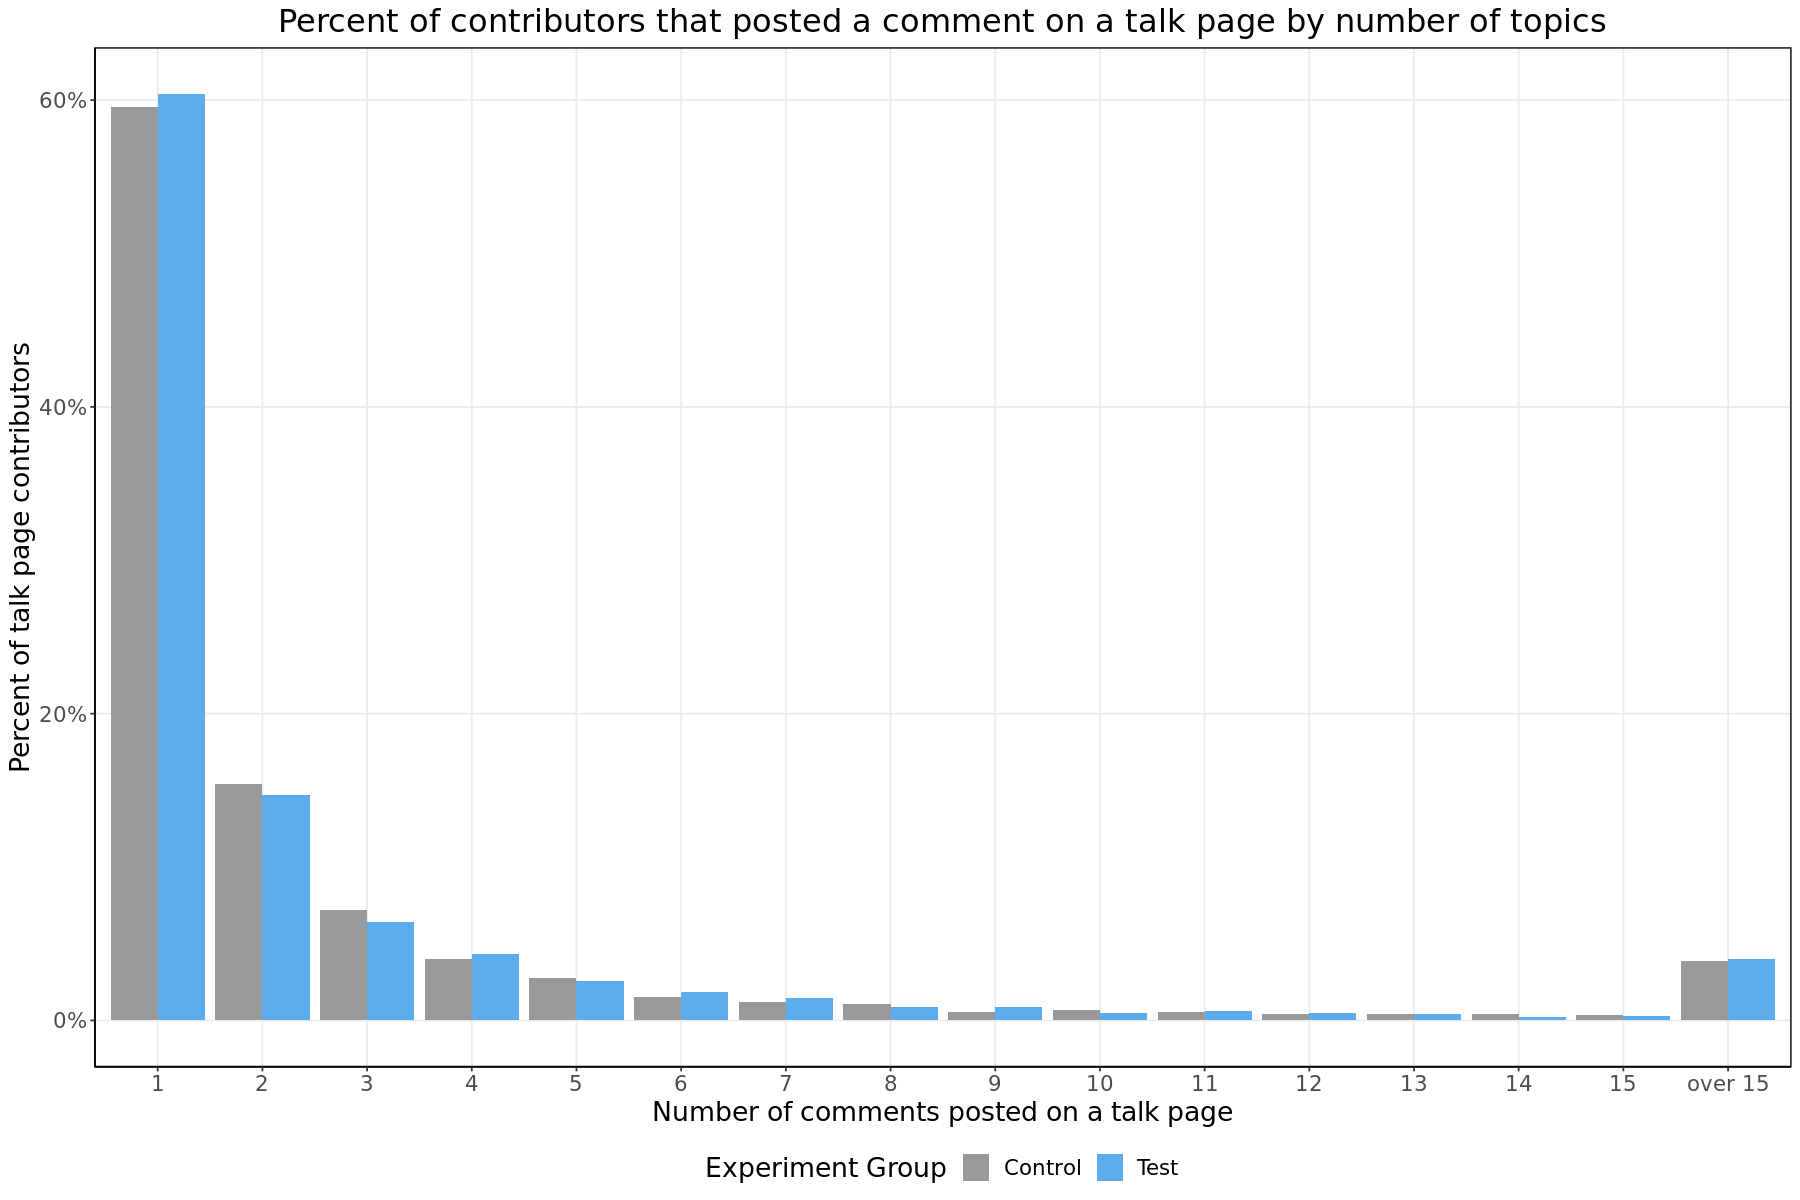

In [89]:
# Chart groups

p <- topic_contributors_bygroup  %>%
    ggplot(aes(x=topic_count_group, y = percent_users, fill =experiment_group)) +
    geom_col(position = 'dodge') +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of talk page contributors",
          x = "Number of comments posted on a talk page",
         title = "Percent of contributors that posted a comment on a talk page by number of topics")  +
     theme_bw() +
   scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group", labels = c("Control", "Test")) + 
  theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black"))     
p

ggsave("Figures/topic_contributors_bygroup", p, width = 16, height = 8, units = "in", dpi = 300)

There are no signficant differences in the number of comments posted on a talk pages by the bucketed users in the test and control groups. For both groups, the majority of contributors (60% in each experiment group) posted only one comment during the duration of the AB test. 

4% of contributors within each group were highly active (posting over 15 comments on a talk page during the duration of the AB test)

###  By experience group

In [90]:
topic_contributors_bygroupexp <- topic_events %>%
 #filter(comment_type == 'topic') %>%
  group_by(experiment_group,experience_group, user_id) %>%
  summarise(n_comments = n_distinct(comment_id)) %>%
  mutate(topic_count_group = cut(n_comments, breaks = b, labels = names))  %>%
  group_by(experiment_group, experience_group, topic_count_group)%>%
  summarise(n_users = n_distinct(user_id)) %>%
    mutate(percent_users = n_users/sum(n_users))


`summarise()` regrouping output by 'experiment_group', 'experience_group' (override with `.groups` argument)

`summarise()` regrouping output by 'experiment_group', 'experience_group' (override with `.groups` argument)



ERROR: Error: Unknown graphics device ''


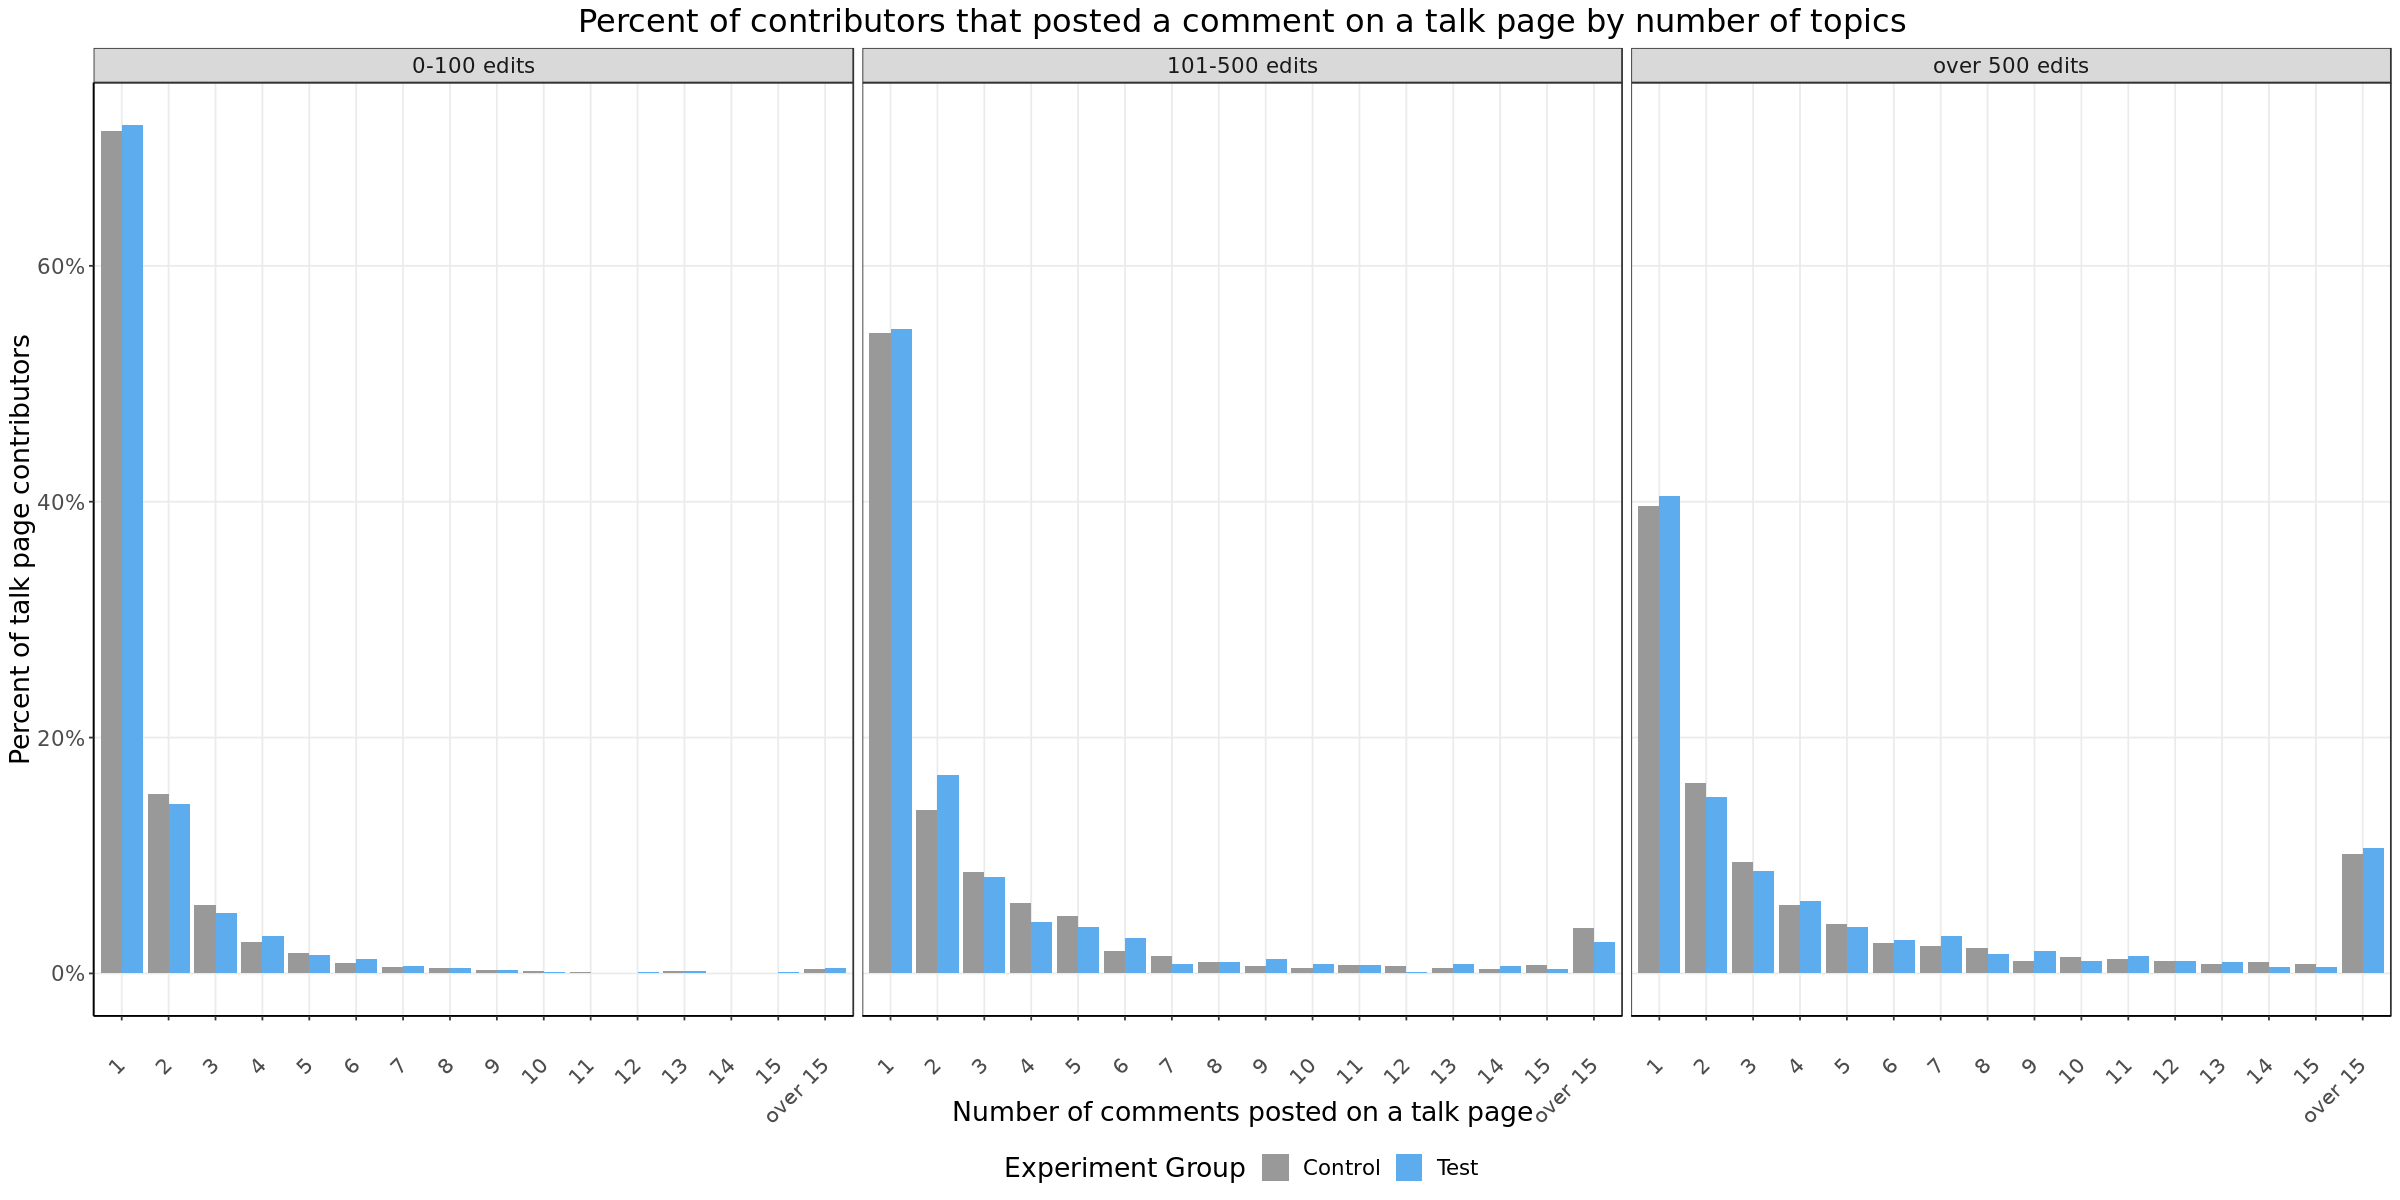

In [95]:
# Chart groups by exp

p <- topic_contributors_bygroupexp  %>%
    ggplot(aes(x=topic_count_group, y = percent_users, fill =experiment_group)) +
    geom_col(position = 'dodge') +
    facet_grid(~ experience_group) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of talk page contributors",
          x = "Number of comments posted on a talk page",
         title = "Percent of contributors that posted a comment on a talk page by number of topics")  +
     theme_bw() +
   scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group", labels = c("Control", "Test")) + 
  theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
         axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1),
        axis.line = element_line(colour = "black"))     
p

ggsave("Figures/topic_contributors_bygroup_exp", p, width = 16, height = 8, units = "in", dpi = 300)

Broken down by experience level, both the test and control experiment groups follow similar trends. Junior contributors most frequently just posted one new topic during the AB test. Senior contributors in both experiment groups typically started a higher number of new topics during the AB test compared to Junior Contribtors.

# Guardrails

# Guardrail #1: Topic Subscriptions should not cause a significant increase in disruptive behavior.

We looked at the following two metrics as indicators of disruption:
A) Sharp increase in the number of notifications sent/contributor/day and B) Sharp increase in the percent of contributors that disable notifications.

## A) Sharp increase in the number of notifications sent/contributor/day 

**Data Source**: [echo_notification table](https://www.mediawiki.org/wiki/Extension:Echo/echo_notification_table?useskin=vector-2022)

Note: Results are limited to participating wikis but not only bucketed users. 

In [57]:
notifications_sent <-
  read.csv(
    file = 'Data/notifications_sent.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads notification data

In [58]:
# remove scientific notations
options(scipen=999)

In [60]:
# convert time sent to date time
notifications_sent$time_sent <- as.Date(as.character(notifications_sent$time_sent), format = "%Y%m%d%H%M%S")

In [61]:
head(notifications_sent)

,notification_user,time_sent,num_notifications
,<int>,<date>,<int>
1,36640,2021-08-27,1
2,36640,2022-01-27,1
3,36640,2022-04-29,1
4,124078,2021-08-27,1
5,40,2021-11-30,1
6,44230,2022-03-31,1


In [92]:
# calculate avg notifications sent per user per day
notifications_sent_byday <- notifications_sent %>%
    group_by(notification_user, time_sent) %>%
    summarise(n_notifications = sum(num_notifications)) %>%
    group_by(time_sent)  %>%
    summarise(avg_daily_notifications = mean(n_notifications))
 

`summarise()` regrouping output by 'notification_user' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



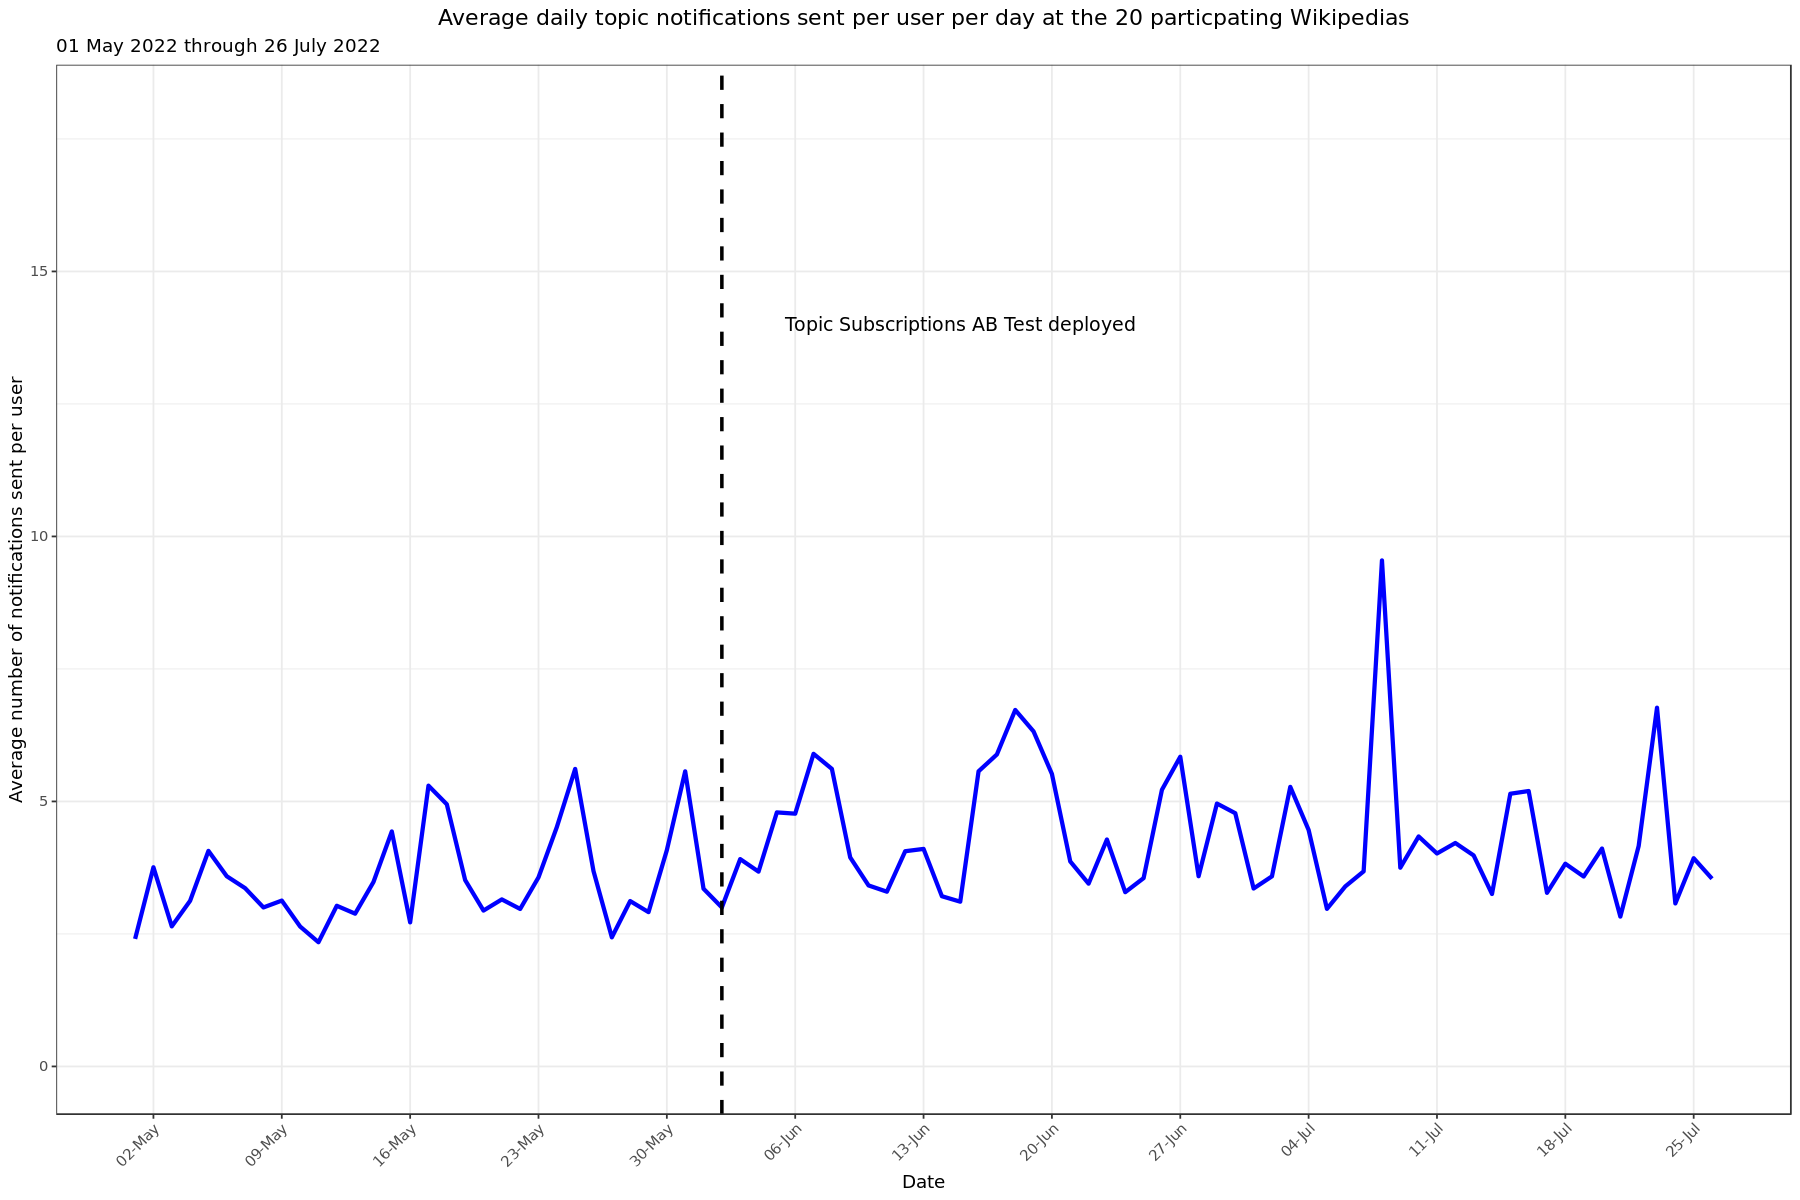

In [93]:
textaes <- data.frame(y = c(14),
                      x = as.Date(c('2022-06-15')),
                      lab = c("Topic Subscriptions AB Test deployed"))

 p <- notifications_sent_byday %>%   
    filter(time_sent >= '2022-05-01')  %>%  
    ggplot(aes(x= time_sent, y = avg_daily_notifications)) +
    geom_line(size = 1.2, color = 'blue') +
    geom_vline(xintercept = as.Date('2022-06-02'), linetype = 'dashed', size = 1) +
    geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 4) +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    labs (y = "Average number of notifications sent per user",
          x = "Date",
         title = "Average daily topic notifications sent per user per day at the 20 particpating Wikipedias",
         subtitle = "01 May 2022 through 26 July 2022")  +
     ylim(0,18)+
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 

p
ggsave("Figures/avg_daily_topic_notifications.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [71]:
# After deployment
notifications_sent_byday %>%
filter(time_sent >= '2022-06-02')  %>% # following deployment of the test
summary()

   time_sent          avg_daily_notifications
 Min.   :2022-06-02   Min.   :2.828          
 1st Qu.:2022-06-15   1st Qu.:3.495          
 Median :2022-06-29   Median :3.981          
 Mean   :2022-06-29   Mean   :4.344          
 3rd Qu.:2022-07-12   3rd Qu.:5.053          
 Max.   :2022-07-26   Max.   :9.547          

In [72]:
# Pre deployment
notifications_sent_byday %>%
filter(time_sent < '2022-06-02')  %>% # following deployment of the test
summary()

   time_sent          avg_daily_notifications
 Min.   :2021-06-28   Min.   : 1.000         
 1st Qu.:2021-09-21   1st Qu.: 2.653         
 Median :2021-12-14   Median : 3.312         
 Mean   :2021-12-14   Mean   : 3.702         
 3rd Qu.:2022-03-08   3rd Qu.: 4.397         
 Max.   :2022-06-01   Max.   :20.194         

The average number of notifications sent per day has remained fairly stable following the deployment of the AB test with a daily average of about 4 notifications per user per day.

### Percent Change Calculation

In [79]:
notificaiton_sent_pct_change  <- notifications_sent %>%
    filter(time_sent >= "2022-05-19" & time_sent <= "2022-06-16") %>% #two weeks before and after
    mutate(pre_post = ifelse(time_sent < '2022-06-02', 'pre', 'post')) %>%
    group_by(pre_post,notification_user, time_sent) %>%
    summarise(n_notifications = sum(num_notifications)) %>%
    group_by(pre_post)  %>%
    summarise(avg_daily_notifications = mean(n_notifications))

notificaiton_sent_pct_change

`summarise()` regrouping output by 'pre_post', 'notification_user' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



pre_post,avg_daily_notifications
<chr>,<dbl>
post,4.216718
pre,3.668076


The average daily notification have increase from about 3.6 to 4.2 notifications per contributor day following the AB test (16% increase). This increase was not sigfnicant or sudden to indicate any disruption.

## B) Sharp increase in the percent of contributors that disable notifications.

### Method #1: PrefUpdate
Data Source: We first reviewed data logged in [PrefUpdate](https://schema.wikimedia.org/#!//secondary/jsonschema/analytics/legacy/prefupdate) to determine any signficant changes in the number of contributors that disable notifications two weeks before and after the debployment of the AB test on participating wikis. 


There are two topic notification preferences: 
* 'discussiontools-topicsubscription'. (Enable topic subscription setting)
* 'discussiontools-autotopicsub' (Automatically subscribe to topics setting)

Notes:
* Properties should be set to either "0" or "1" to indicate current status; however, a review of the dataset shows some instances being logged at TRUE and FALASE.
* PrefUpdate logs whether the change is from or to a default value. It is unclear how this is handled in an AB test where the defaults was adjusted for each group.


In [257]:
query <- 
"
SELECT
event.savetimestamp as save_time,
event.property AS pref_type,
wiki AS wiki,
event.userid AS pref_user,
event.value AS value,
MIN(event.bucketedusereditcount) AS user_experience,
COUNT(*) AS n_times
FROM 
event.prefupdate
WHERE
year = 2022
AND month  >= 05
AND event.property IN ('discussiontools-topicsubscription', 'discussiontools-autotopicsub')
-- only at participating wikis
AND wiki IN ('amwiki', 'arzwiki', 'bnwiki', 'eswiki', 'fawiki', 'frwiki', 'hewiki',  'hiwiki',  'idwiki', 'itwiki',  'jawiki',  
 'kowiki', 'nlwiki', 'omwiki', 'plwiki', 'ptwiki',  'thwiki',
    'ukwiki', 'viwiki','zhwiki')
-- only logged in users
AND useragent.is_bot = false
GROUP BY
event.savetimestamp,
event.property,
wiki,
event.userid,
event.value
"




In [258]:
sub_pref_changes <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [259]:
# convert time sent to date time
sub_pref_changes$save_time <- as.Date(as.character(sub_pref_changes$save_time), format = "%Y%m%d%H%M%S")

In [261]:
sub_pref_changes_bytype <- sub_pref_changes %>%
    filter(save_time >= "2022-05-19" & save_time <= "2022-06-16") %>% #two weeks before and after
    mutate(pre_post = ifelse(save_time < '2022-06-02', 'pre', 'post')) %>%
    group_by(pre_post, pref_type, value) %>%
    summarise(n_users_pref = n_distinct(pref_user))

sub_pref_changes_bytype

`summarise()` regrouping output by 'pre_post', 'pref_type' (override with `.groups` argument)



pre_post,pref_type,value,n_users_pref
<chr>,<chr>,<chr>,<int>
post,discussiontools-autotopicsub,0,3
post,discussiontools-autotopicsub,true,23
post,discussiontools-topicsubscription,"""0""",1
post,discussiontools-topicsubscription,1,2
post,discussiontools-topicsubscription,false,20
pre,discussiontools-autotopicsub,0,9
pre,discussiontools-topicsubscription,false,9


There have been no significant changes in the percent of contriburors that have disabled the feature looking at either of the possible values in PrefUpdate (0 or false).  

## Method 2: User Property Table

Since it is difficult to discern the values using pref update, we next used to the [user property](https://www.mediawiki.org/wiki/Manual:User_properties_table/en?useskin=vector-2022) table to determine the current preference settings of users that have received a notification.

I used  the `sub_created` date logged in the [discussiontools_subscription table](https://www.mediawiki.org/wiki/Extension:DiscussionTools/discussiontools_subscription_table?useskin=vector-2022)to determine the percent of users that subscribed to either a manual or automatic notification before or after the AB test and then disabled it. 

### Manual Topic Subscriptions

Notes:
*The automatic topic subscription preference is only recorded when the user turns on the preference. It does not appear when it is disabled. 
* The manual topic subscription preference is not recorded when the user opts into the beta preference as it is enabled by default. It only shows when disabled.

In [112]:
notifications_users_disabled <-
  read.csv(
    file = 'Data/notification_users_disabled_manual.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads notification data

In [113]:
# convert time sent to date time
notifications_users_disabled$sub_created <- as.Date(as.character(notifications_users_disabled$sub_created), format = "%Y%m%d%H%M%S")

In [117]:
#Find percent of all users that received a notification and disabled the feature
notification_users_disabled_disabled_pct <- notifications_users_disabled %>%
   mutate(pre_post = ifelse(sub_created <= '2022-06-02', 'pre', 'post')) %>%
    group_by(pre_post)  %>%
    summarise(notification_users = n(),
             topic_disabled = sum(topic_user != "NaN"), #disabled if the feature is present
              pct_disabled = paste0(round(topic_disabled/notification_users * 100, 2), '%'))

notification_users_disabled_disabled_pct



`summarise()` ungrouping output (override with `.groups` argument)



pre_post,notification_users,topic_disabled,pct_disabled
<chr>,<int>,<int>,<chr>
post,888,0,0%
pre,1253,9,0.72%


Following the deployment of the AB test, there have been 888 users across all participating wikis that have manually subscribed to a topic. None of those users have explicilty disabled that preference as of the end of the AB test (15 July 2022).

In comparison, 0.72% of users that manually subscribed to a topic on participating wikis prior to the AB test disabled that preference.

### Automatic topic subscriptions

Note: 
* The automatic topic subscription preference is only recorded when the user turns on the preference. It does not appear when it is disabled. 

In [119]:
notifications_users_disabled_auto <-
  read.csv(
    file = 'Data/notification_users_disabled_auto.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads notification data

In [121]:

auto_topic_subscribers_disabled_pct <- notifications_users_disabled_auto %>%
    mutate(pre_post = ifelse(sub_created <= '2022-06-02', 'pre', 'post')) %>%
    group_by(pre_post) %>%
    summarise(auto_subscribers = n(),
             auto_disabled = sum(auto_user == "NaN"),
              pct_disabled = auto_disabled/auto_subscribers * 100)

auto_topic_subscribers_disabled_pct

`summarise()` ungrouping output (override with `.groups` argument)



pre_post,auto_subscribers,auto_disabled,pct_disabled
<chr>,<int>,<int>,<dbl>
post,682,135,19.79472


About 19% of users on participating wikis that were autosubscribed to a topic following the deployment of the AB test disabled the feature.  

No users in the AB test were automatically subscribed to a topic prior to the deployment of the AB test; however, this percentage is only slightly higher then the overall rates of users that disabled the  automatic topic notification preference found in the adoption metrics report (18%). 

# Guardrail #2: Average time between when a new comment or new topic is published and someone responding to said comment or topic

As observed in the response times identified in the KPI section above, we did not observe any sharp increase in the the average time it takes for people to respond to comments and new topics that are posted to wikitext talk pages. The median response time in the test group was 57% faster than the median response time in the control group. Additionally, there was few long (over 10 day) response times in the test group compared to the control group.

We did observe a few experience level groups (Senior Contributors) and wikis where there was a higher median response time to comments and topics posted in the test group compared to the control group. Further investigation is needed to help clarfiy the source of these differences.

Please see KPI section for additional details. 

# Guardrail #3: Percent change in the number of Senior Contributors making edits to talk page

Topic Subscriptions should not cause a significant (read: sharp) increase or decrease in the number of Senior Contributors editing talk pages.

For this analysis, we conducted a pre and post deployment analysis to determine any signficant changes in the number of contributors that started an edit to a talk page on the wikis where the AB test was deployed. Since we are including events logged prior to the AB test, we did not limit data to just the AB test but all edit attempts logged before and after deployment.

In [336]:
query <-
"SELECT
date_format(dt, 'yyyy-MM-dd') as attempt_dt,
event.user_id,
wiki,
COUNT(*) as n_edits
FROM
event.editattemptstep
WHERE
Year = 2022
AND month >= 05  --look at some time prior and post deployment of the AB test
AND event.action = 'init'
AND useragent.is_bot = false
-- review all talk namespaces
  AND event.page_ns % 2 = 1
   AND event.platform = 'desktop'
   AND event.action = 'init'
-- review participating wikis list
  AND wiki IN ('amwiki', 'arzwiki', 'bnwiki', 'eswiki', 'fawiki', 'frwiki', 'hewiki',  'hiwiki',  'idwiki', 'itwiki',  'jawiki',  
 'kowiki', 'nlwiki', 'omwiki', 'plwiki', 'ptwiki',  'thwiki',
    'ukwiki', 'viwiki','zhwiki')
-- only logged in users
  AND event.user_id != 0 
  AND event.user_editcount > 500 -- only senior editrs
GROUP BY
date_format(dt, 'yyyy-MM-dd'),
event.user_id,
wiki
"

In [337]:
senior_contributor_edits <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [338]:
# convert time sent to date time
senior_contributor_edits$attempt_dt <- as.Date(senior_contributor_edits$attempt_dt, format = "%Y-%m-%d")

In [339]:
senior_contributor_daily_edits  <- senior_contributor_edits %>%
    group_by(attempt_dt) %>%
    summarise(n_users = n_distinct(user_id))

`summarise()` ungrouping output (override with `.groups` argument)



ERROR: Error: Unknown graphics device ''


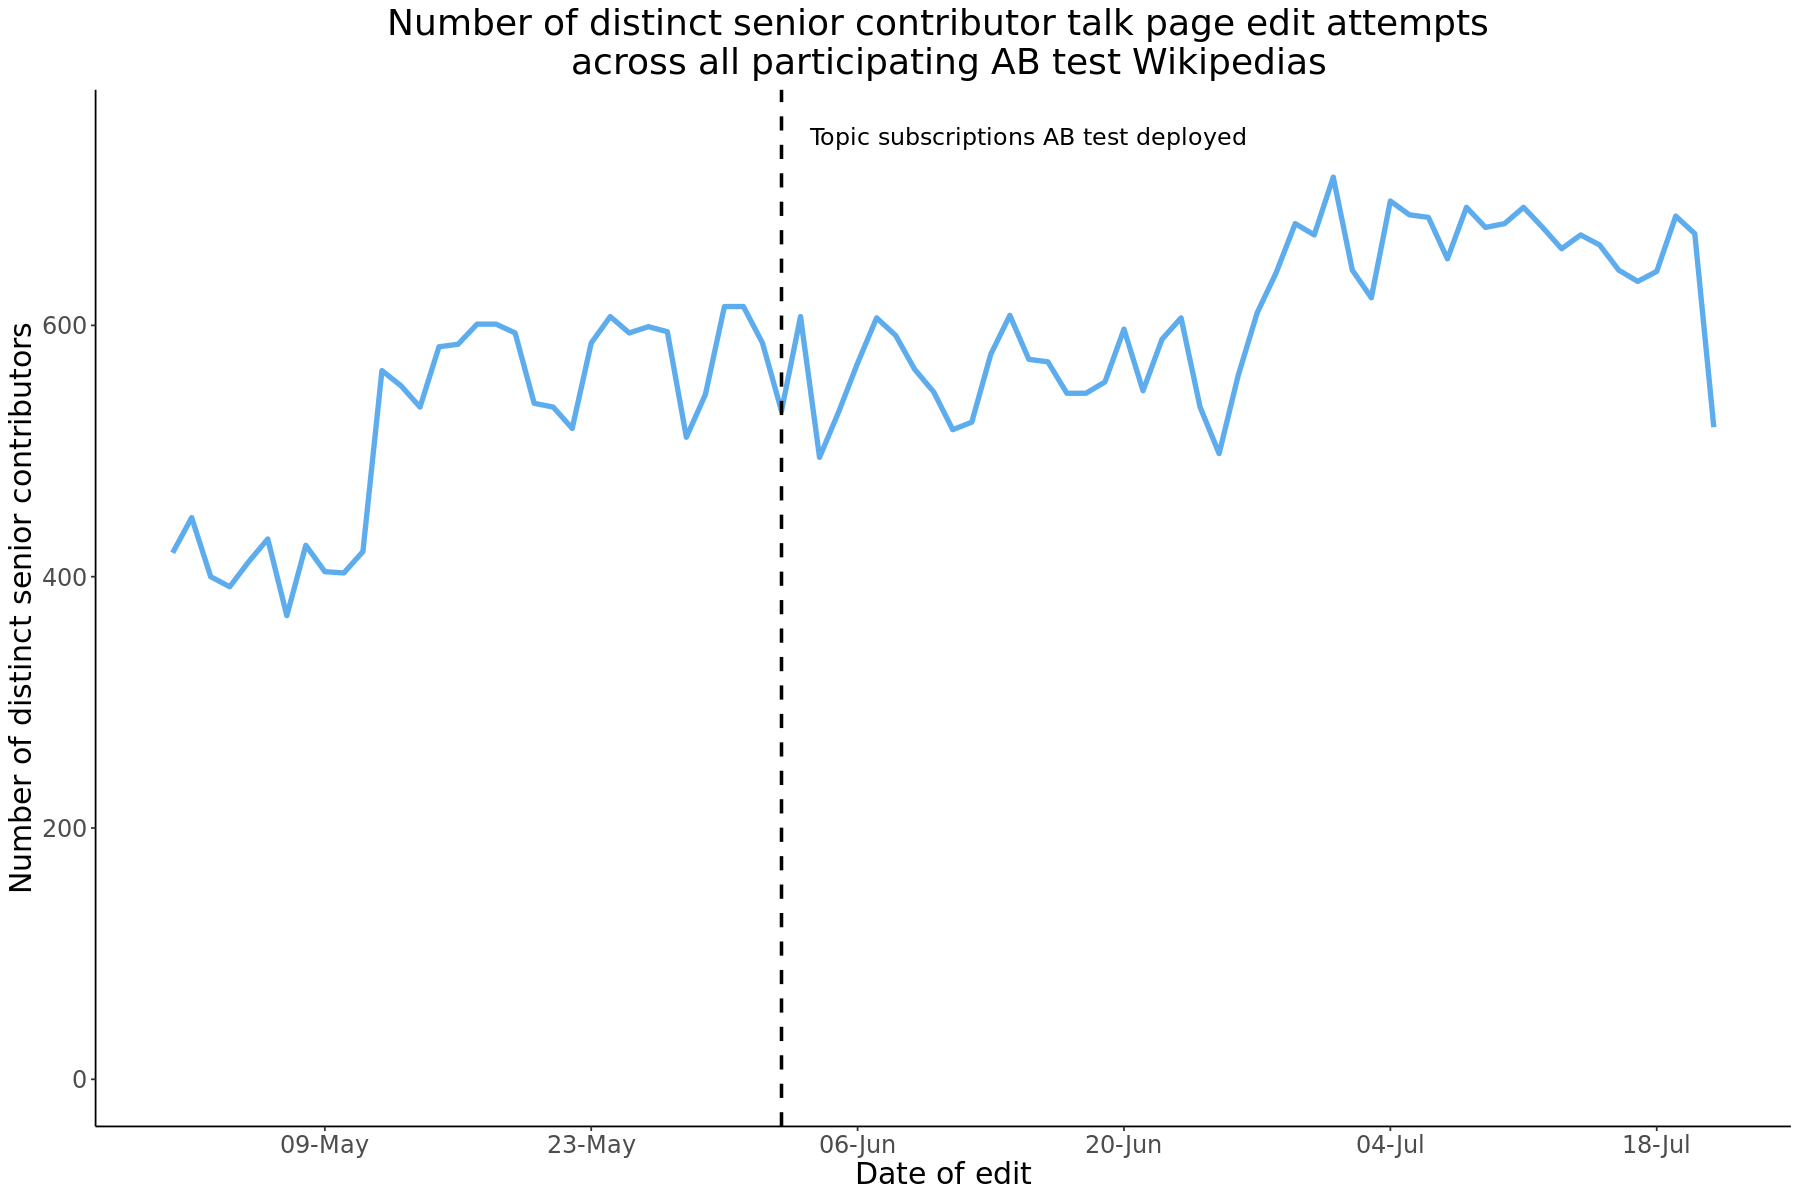

In [476]:
# Plot edit completion rates for each user on each wiki  


textaes <- data.frame(y = 750,
                      x = as.Date('2022-06-15'),
                      lab = "Topic subscriptions AB test deployed")

p <- senior_contributor_daily_edits %>%
    ggplot(aes(x= attempt_dt, y = n_users)) +
    geom_line(size = 1.5,color = "steelblue2") +
    geom_vline(xintercept = as.Date('2022-06-02'), linetype = 'dashed', size = 1) +
    scale_x_date(date_labels = "%d-%b", date_breaks = "2 weeks", minor_breaks = NULL) +
    scale_y_continuous(limit = c(0, 750)) +
    geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 5) +
    labs (y = "Number of distinct senior contributors",
          x = "Date of edit",
          title = "Number of distinct senior contributor talk page edit attempts \n across all participating AB test Wikipedias"
          )+
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

p 
ggsave("Figures/senior_contributor_daily_edits", p, width = 16, height = 8, units = "in", dpi = 300)

### Percent change calculation

In [365]:
senior_contributor_pct_change  <- senior_contributor_edits %>%
    filter(attempt_dt >= "2022-05-19" & attempt_dt <= "2022-06-16") %>% #two weeks before and after
    mutate(pre_post = ifelse(attempt_dt < '2022-06-02', 'pre', 'post')) %>%
    group_by(pre_post) %>%
    summarise(n_users = n_distinct(user_id))

senior_contributor_pct_change

`summarise()` ungrouping output (override with `.groups` argument)



pre_post,n_users
<chr>,<int>
post,3035
pre,3054


Before and after the AB test deployment, we only see less than a 1% change in the number of distinct senior contributors.

## By Wiki

In [366]:
senior_contributor_daily_edits_wiki  <- senior_contributor_edits %>%
    group_by(wiki, attempt_dt) %>%
    summarise(n_users = n_distinct(user_id))

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



In [375]:
senior_contributor_pct_change_wiki  <- senior_contributor_edits %>%
    filter(attempt_dt >= "2022-05-19" & attempt_dt <= "2022-06-16") %>% #two weeks before and after
    mutate(pre_post = ifelse(attempt_dt < '2022-06-02', 'pre', 'post')) %>%
    group_by( wiki, pre_post) %>%
    summarise(n_users = n_distinct(user_id)) %>%
    pivot_wider(names_from = pre_post, values_from = n_users)%>%
    arrange(wiki)

senior_contributor_pct_change_wiki

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,post,pre
<chr>,<int>,<int>
arzwiki,2,3
bnwiki,32,35
eswiki,337,332
fawiki,91,103
frwiki,624,621
hewiki,226,224
hiwiki,7,6
idwiki,54,38
itwiki,386,374


There were no signficant changes in the number of senior contributors on a per wiki basis.